In [14]:
##### load libraries
library(dplyr)
library("edgeR")
library(Matrix)
library(gplots)
library(RColorBrewer)
library(irlba)
library(proxy)
library(png)
library(tidyverse)
library(ComplexHeatmap)
library(here)


working_dir <- "/scratch/jpm73279/comparative_single_cell/08.annotation_figures/zea_mays"
setwd("/scratch/jpm73279/comparative_single_cell/08.annotation_figures/zea_mays")
file_names <- c(
    "00.data/Zm.DA_genes.up_reg_test/Cluster_bundle_sheath_ncell_2870.DA_list.txt",
    "00.data/Zm.DA_genes.up_reg_test/Cluster_companion_cells_ncell_647.DA_list.txt",
    "00.data/Zm.DA_genes.up_reg_test/Cluster_developing_mesophyll_ncell_494.DA_list.txt",
    "00.data/Zm.DA_genes.up_reg_test/Cluster_epidermal_ncell_3135.DA_list.txt",
    "00.data/Zm.DA_genes.up_reg_test/Cluster_guard_cell_ncell_285.DA_list.txt",
    "00.data/Zm.DA_genes.up_reg_test/Cluster_mesophyll_ncell_4541.DA_list.txt",
    "00.data/Zm.DA_genes.up_reg_test/Cluster_metaphloem_sieve_element_ncell_114.DA_list.txt",
    "00.data/Zm.DA_genes.up_reg_test/Cluster_procambium_ncell_372.DA_list.txt",
    "00.data/Zm.DA_genes.up_reg_test/Cluster_protoderm_ncell_1292.DA_list.txt",
    "00.data/Zm.DA_genes.up_reg_test/Cluster_subsidary_cell_ncell_117.DA_list.txt",
    "00.data/Zm.DA_genes.up_reg_test/Cluster_unknown_ncell_574.DA_list.txt",
    "00.data/Zm.DA_genes.up_reg_test/Cluster_vascular_parenchyma_ncell_1231.DA_list.txt",
    "00.data/Zm.DA_genes.up_reg_test/Cluster_xylem_ncell_336.DA_list.txt")

read_DA_genes <- function(file_name){
    working_dir <- "/scratch/jpm73279/comparative_single_cell/08.annotation_figures/zea_mays"

    filtered <- read_tsv(here(working_dir,file_name), col_names = TRUE,id = "origin")  %>% 
        dplyr::mutate(origin = str_replace(origin, paste0(working_dir, "/00.data/Zm.DA_genes.up_reg_test/"), ""))  %>% 
        dplyr::mutate(origin = str_replace(origin, ".DA_list.txt", ""))  %>% 
        distinct() %>% 
        head(n=5, with_ties = FALSE)
    
    return(filtered)    
}

read_all_DA_genes <- lapply(file_names, read_DA_genes)
all_merzge_values <- data.table::rbindlist(read_all_DA_genes)

merge_values <- all_merge_values
    

table(merge_values$gene_name)

Rows: 4479 Columns: 9
── Column specification ──────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): gene_name, origin
dbl (6): baseMean, log2FoldChange, lfcSE, stat, pvalue, padj

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


ERROR: [1m[33mError[39m in [1m[1m`dplyr::mutate()`:[22m
[1m[22m[33m![39m Can't transform a data frame with duplicate names.


In [ ]:
(merge_values)

In [ ]:
# load arguments
#args <- commandArgs(T)
#if(length(args)!=5){stop("Rscript normGBA.R <gene.sparse> <meta> <Zea_mays.AGPv4.36.Allgene.nuclear.bed> <prefix> <F>")}
#input_data <- as.character(args[1])
#meta <- as.character(args[2])
#gene <- as.character(args[3])
#prefix <- as.character(args[4])


input <- here(working_dir,"00.data/zea_mays.gene_body_acc_leaf_V3_clustering_strict.counts.tab.txt")
meta <- here(working_dir,"00.data/Zm_leaf.V3_final.txt")
gene <- here(working_dir,"00.data/Zm.markers.leaf.txt")
gene_DA <- here(working_dir,"00.data/Zm-B73-REFERENCE-NAM_Zm00001eb.1.genes.bed")

meta_data <- read.delim(meta)
gene_markers <- read.delim(gene)
gene_markers <- gene_markers  %>%
    arrange(type)

all_markers <- gene_markers$geneID

raw_cpm_counts_all_genes <- read_delim(input, delim="\t", col_names = c("gene_name", "barcode", "accessability")) %>%
    dplyr::mutate(cellID = barcode)  %>%
    dplyr::mutate(geneID = gene_name)

colnames(meta_data)

merged_meta_cpm_information <- left_join(meta_data, raw_cpm_counts_all_genes, by = c("cellID"))  %>%
    #mutate(safe_cluster_name = str_c("Louvain_C", LouvainClusters, sep ="_"))  %>%
    #dplyr::select(-LouvainClusters)  %>%
    group_by(V3_annotation_n, geneID)  %>%
    summarise(counts = sum(accessability, na.rm = TRUE))

### Alt CPM Calc
merged_meta_cpm_information_copied <- merged_meta_cpm_information
catch <- merged_meta_cpm_information_copied  %>%
    group_by(V3_annotation_n) %>%
    group_map(~(cpm(.x$counts, log = FALSE, group = .f)), .keep = TRUE)  %>%
    unlist()



caught_values <- as_tibble(catch)
see <- ungroup(merged_meta_cpm_information_copied)
merged_meta_cpm_information_copied<- bind_cols(merged_meta_cpm_information_copied,caught_values)  %>% 
    rename(grouped_CPM = value)


head(merged_meta_cpm_information_copied)
test_wider <- merged_meta_cpm_information_copied %>% 
    dplyr::select(-counts) %>% 
    pivot_wider(names_from = geneID, values_from = grouped_CPM, values_fill = 0) %>% 
    pivot_longer(cols = -V3_annotation_n, names_to = "geneID", values_to = "grouped_CPM") %>% 
    group_by(geneID) %>% 
    mutate(Zscore = scale(grouped_CPM)) %>% 
    ungroup()  %>% 
    #mutate(relative_accessability = rescale(Zscore, to = c(0,1))) %>% 
    group_by(V3_annotation_n)  %>% 
    mutate(Zscore_group = scale(grouped_CPM)) %>% 
    filter(geneID %in% merge_values$gene_name)

    
    

In [ ]:
# Create Proportion Cells Accessible Metrics ------------------------------
merged_meta_cellID_values <- left_join(meta_data, raw_cpm_counts_all_genes, by = c("cellID"))
take_unq_genes <- unique(merged_meta_cellID_values$geneID)


merged_meta_cellID_values_all_genes <- merged_meta_cellID_values %>% 
    select(cellID, V3_annotation_n, accessability, geneID) 


colnames(merged_meta_cellID_values_all_genes)
colnames(merged_meta_cellID_values_all_genes)

wider_all_genes <- merged_meta_cellID_values_all_genes %>% 
                    filter(geneID %in% merge_values$gene_name) %>% 
                    pivot_wider(names_from = geneID, 
                                values_from = accessability,  
                                values_fill = 0) %>% 
                    pivot_longer(cols = c(-V3_annotation_n, -cellID), 
                                 names_to = "geneID", 
                                 values_to = "accessability") %>% 
                    mutate(expression_bool = case_when(accessability <= 1 ~ 0,
                                                       accessability > 1 ~ 1)) %>% 
                    group_by(V3_annotation_n, geneID) %>% 
                    summarise(total_cells = n(), 
                              proportion_expressing = (sum(expression_bool)/total_cells * 100))


colnames(merged_meta_cellID_values_all_genes)
merged_meta_cellID_values_all_genes %>% 
    group_by(V3_annotation_n) %>% 
    select(-accessability, -cellID) %>% 
    unique() %>% 
    summarise(count = n())



final_plotting_dot <- left_join(test_wider, wider_all_genes, by = c("V3_annotation_n", "geneID")) %>% 
        left_join(., merge_values, by = c("geneID" = "gene_name")) %>% 
        mutate(plotting_name = str_c(origin,geneID, sep = "__"))

Loading required package: viridisLite



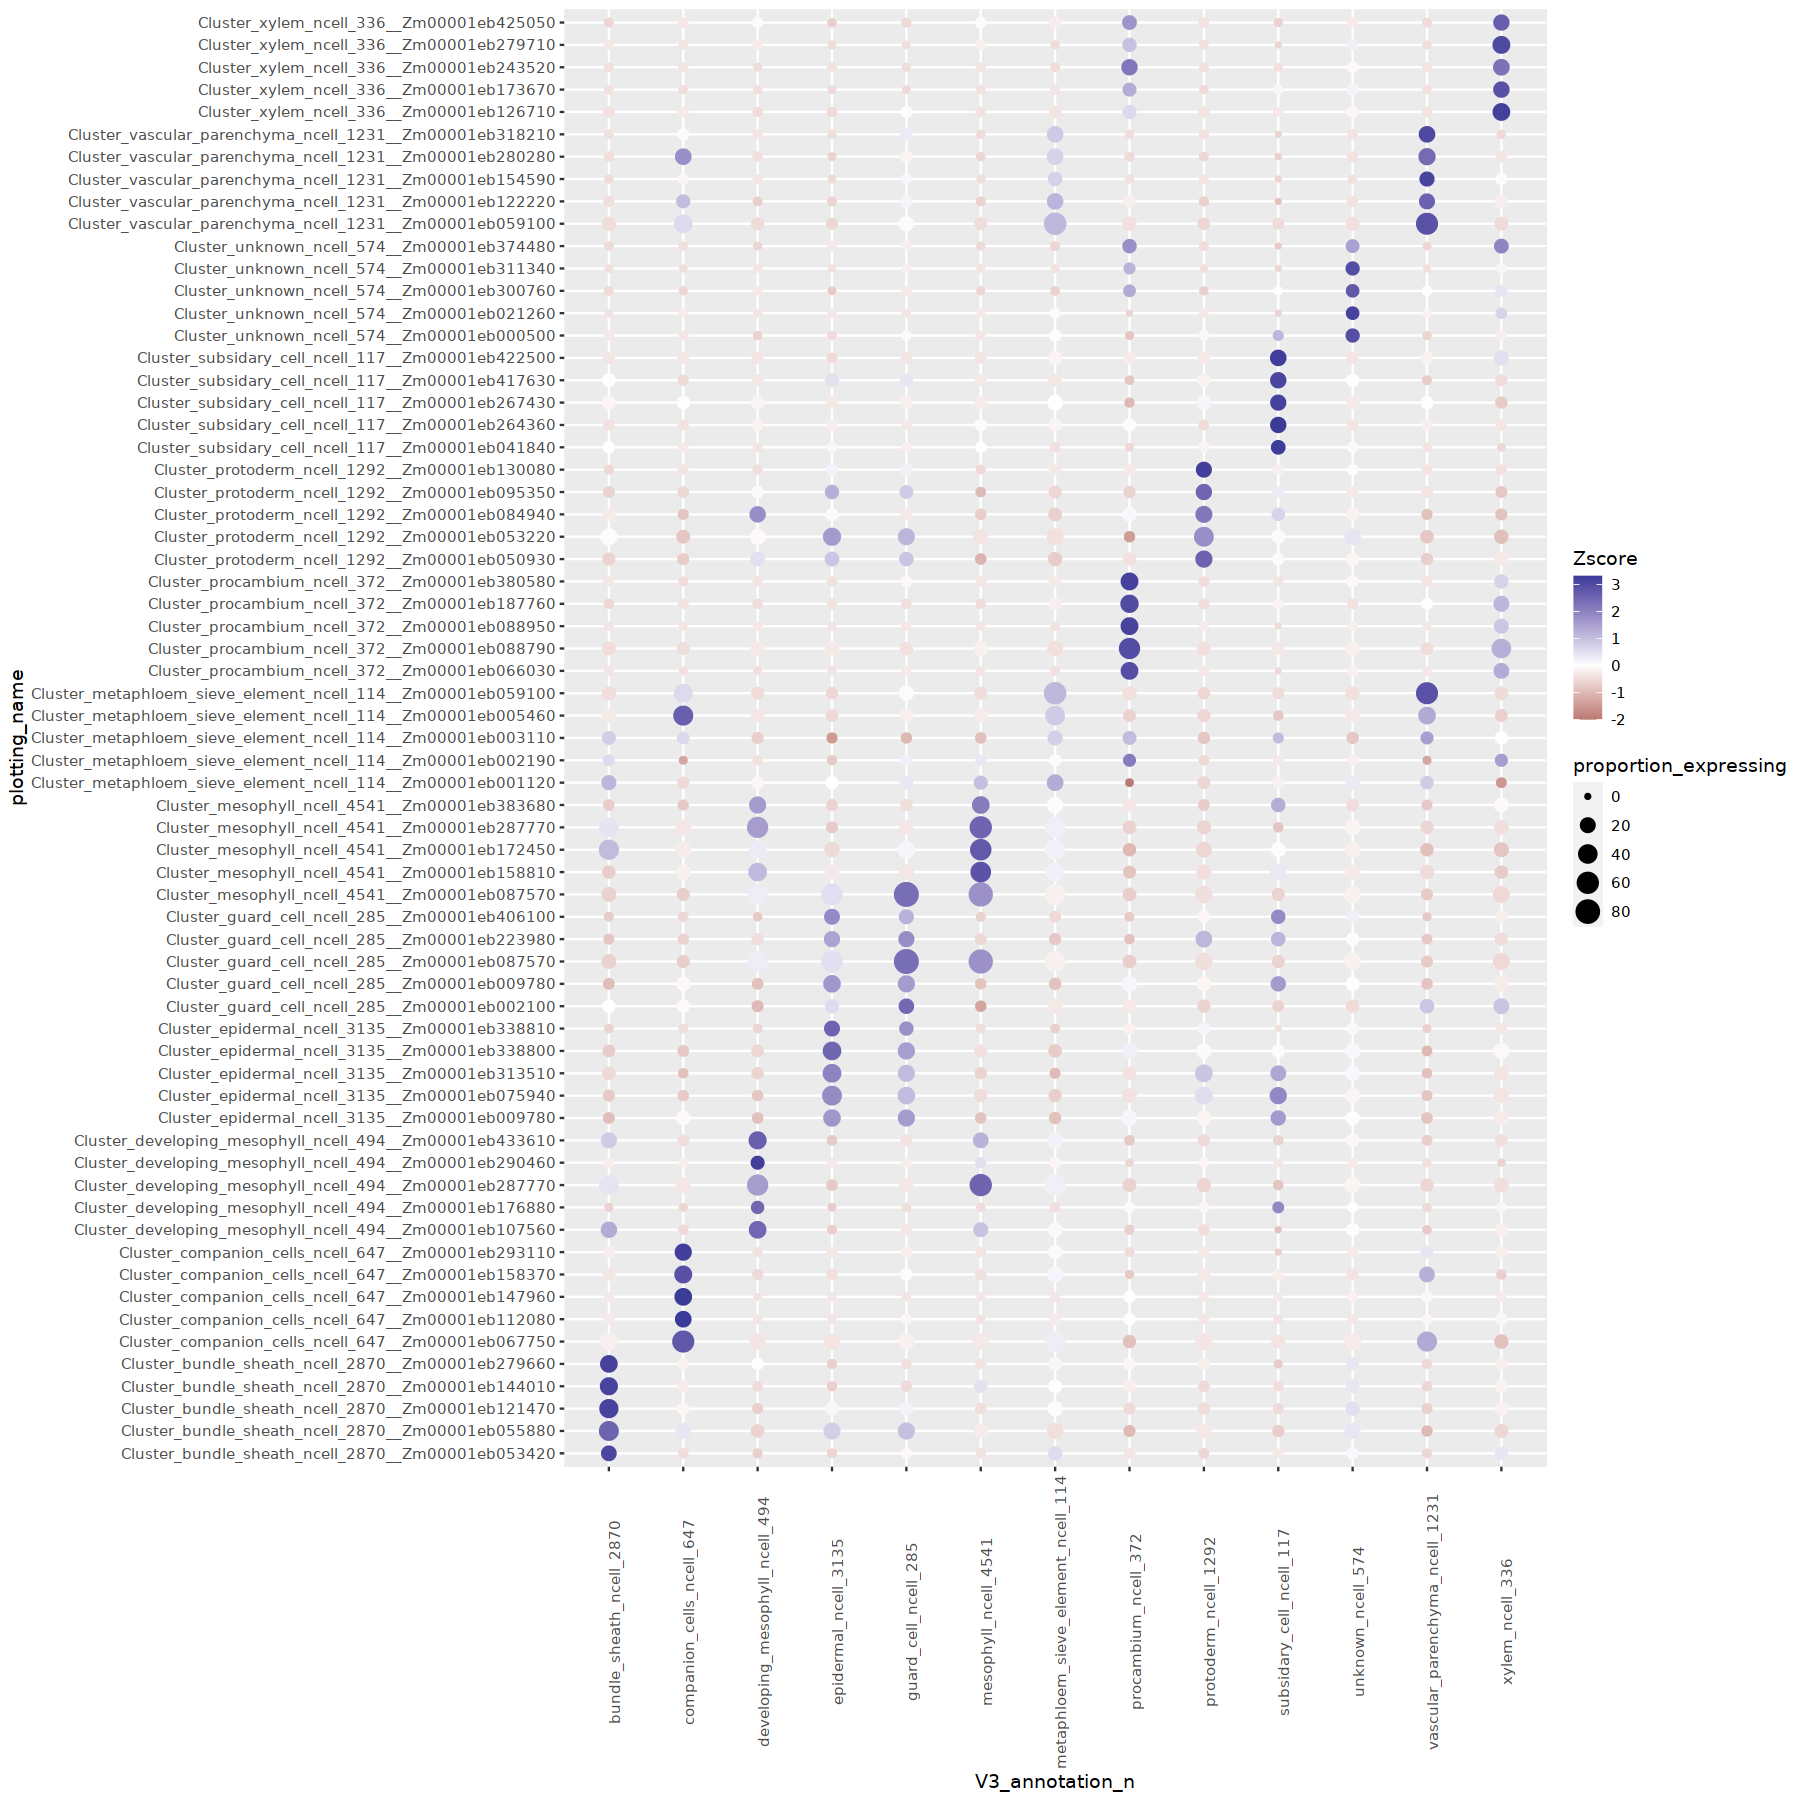

In [6]:
library(viridis)
library(repr)
options(repr.plot.width=15, repr.plot.height=15)

ggplot(final_plotting_dot, aes(x=V3_annotation_n, y = plotting_name, 
                               color = Zscore, size = proportion_expressing)) + 
    geom_point() + theme(axis.text.x = element_text(angle = 90)) + scale_colour_gradient2() + 
    theme(axis.text.x = element_text(size = 15),
         axis.text.y = element_text(size = 10)) +  coord_flip()

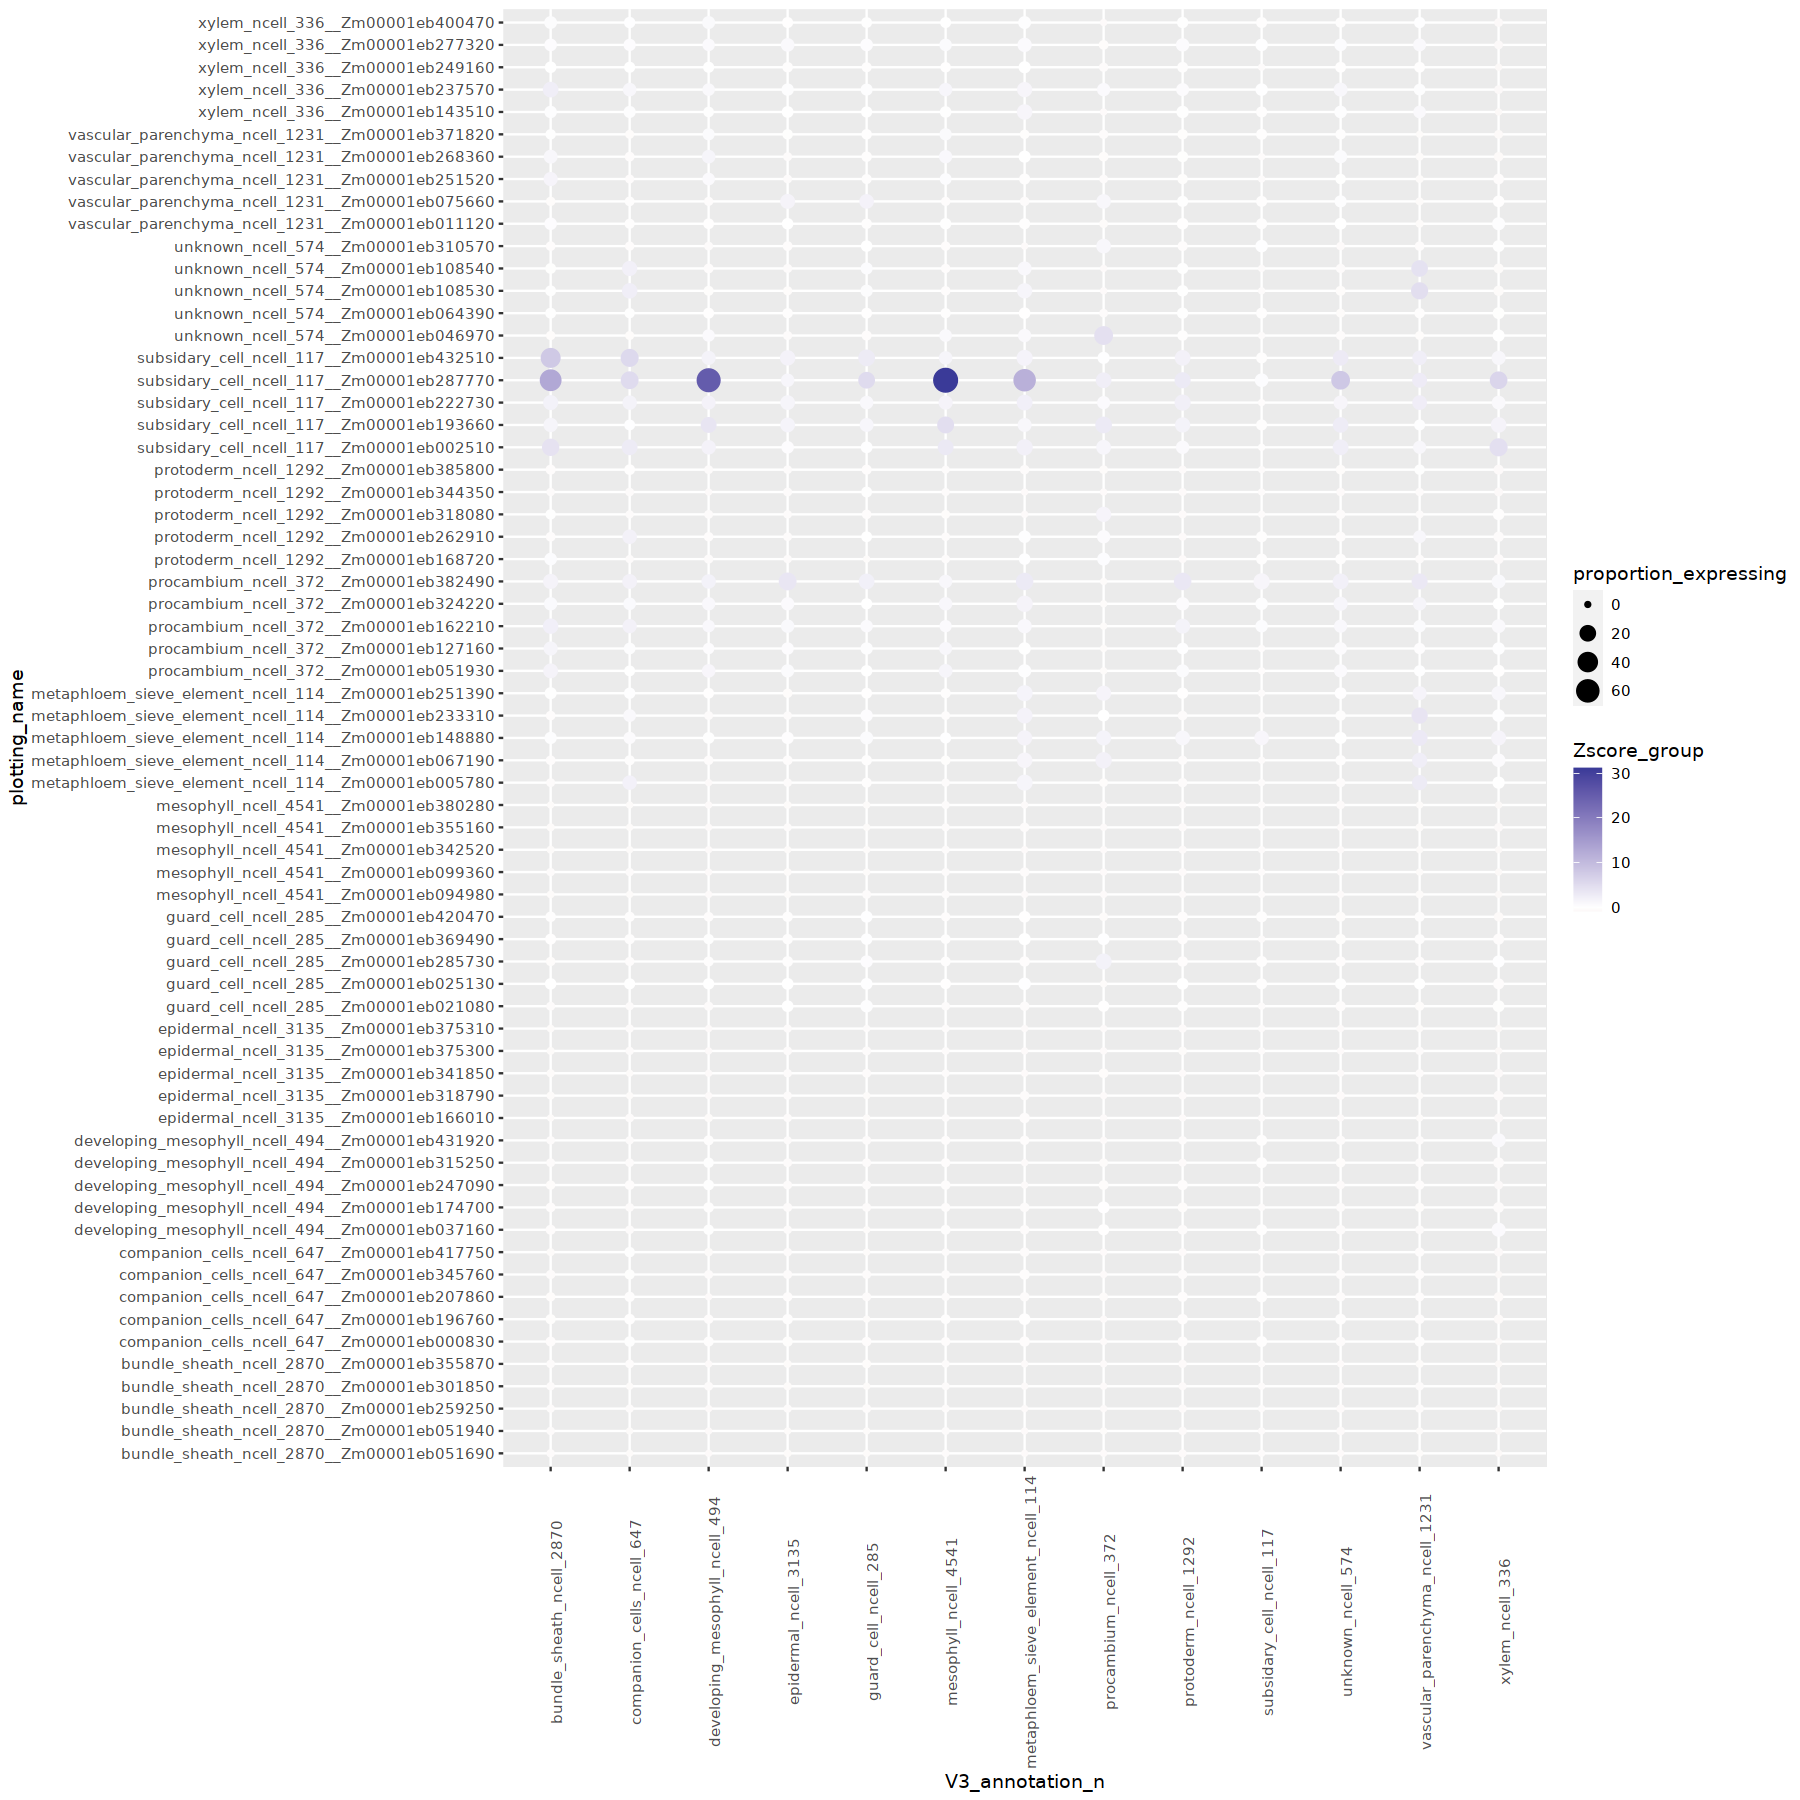

In [15]:
library(viridis)
library(repr)
options(repr.plot.width=15, repr.plot.height=15)


ggplot(final_plotting_dot, aes(x=V3_annotation_n, y = plotting_name, 
                               color = Zscore_group, size = proportion_expressing)) + 
    geom_point() + theme(axis.text.x = element_text(angle = 90)) + scale_colour_gradient2()

In [42]:
unique(final_plotting_dot$V3_annotation_n)

[1] "bundle_sheath_ncell_2870"           "companion_cells_ncell_647"         
 [3] "developing_mesophyll_ncell_494"     "epidermal_ncell_3135"              
 [5] "guard_cell_ncell_285"               "mesophyll_ncell_4541"              
 [7] "metaphloem_sieve_element_ncell_114" "procambium_ncell_372"              
 [9] "protoderm_ncell_1292"               "subsidary_cell_ncell_117"          
[11] "unknown_ncell_574"                  "vascular_parenchyma_ncell_1231"    
[13] "xylem_ncell_336"

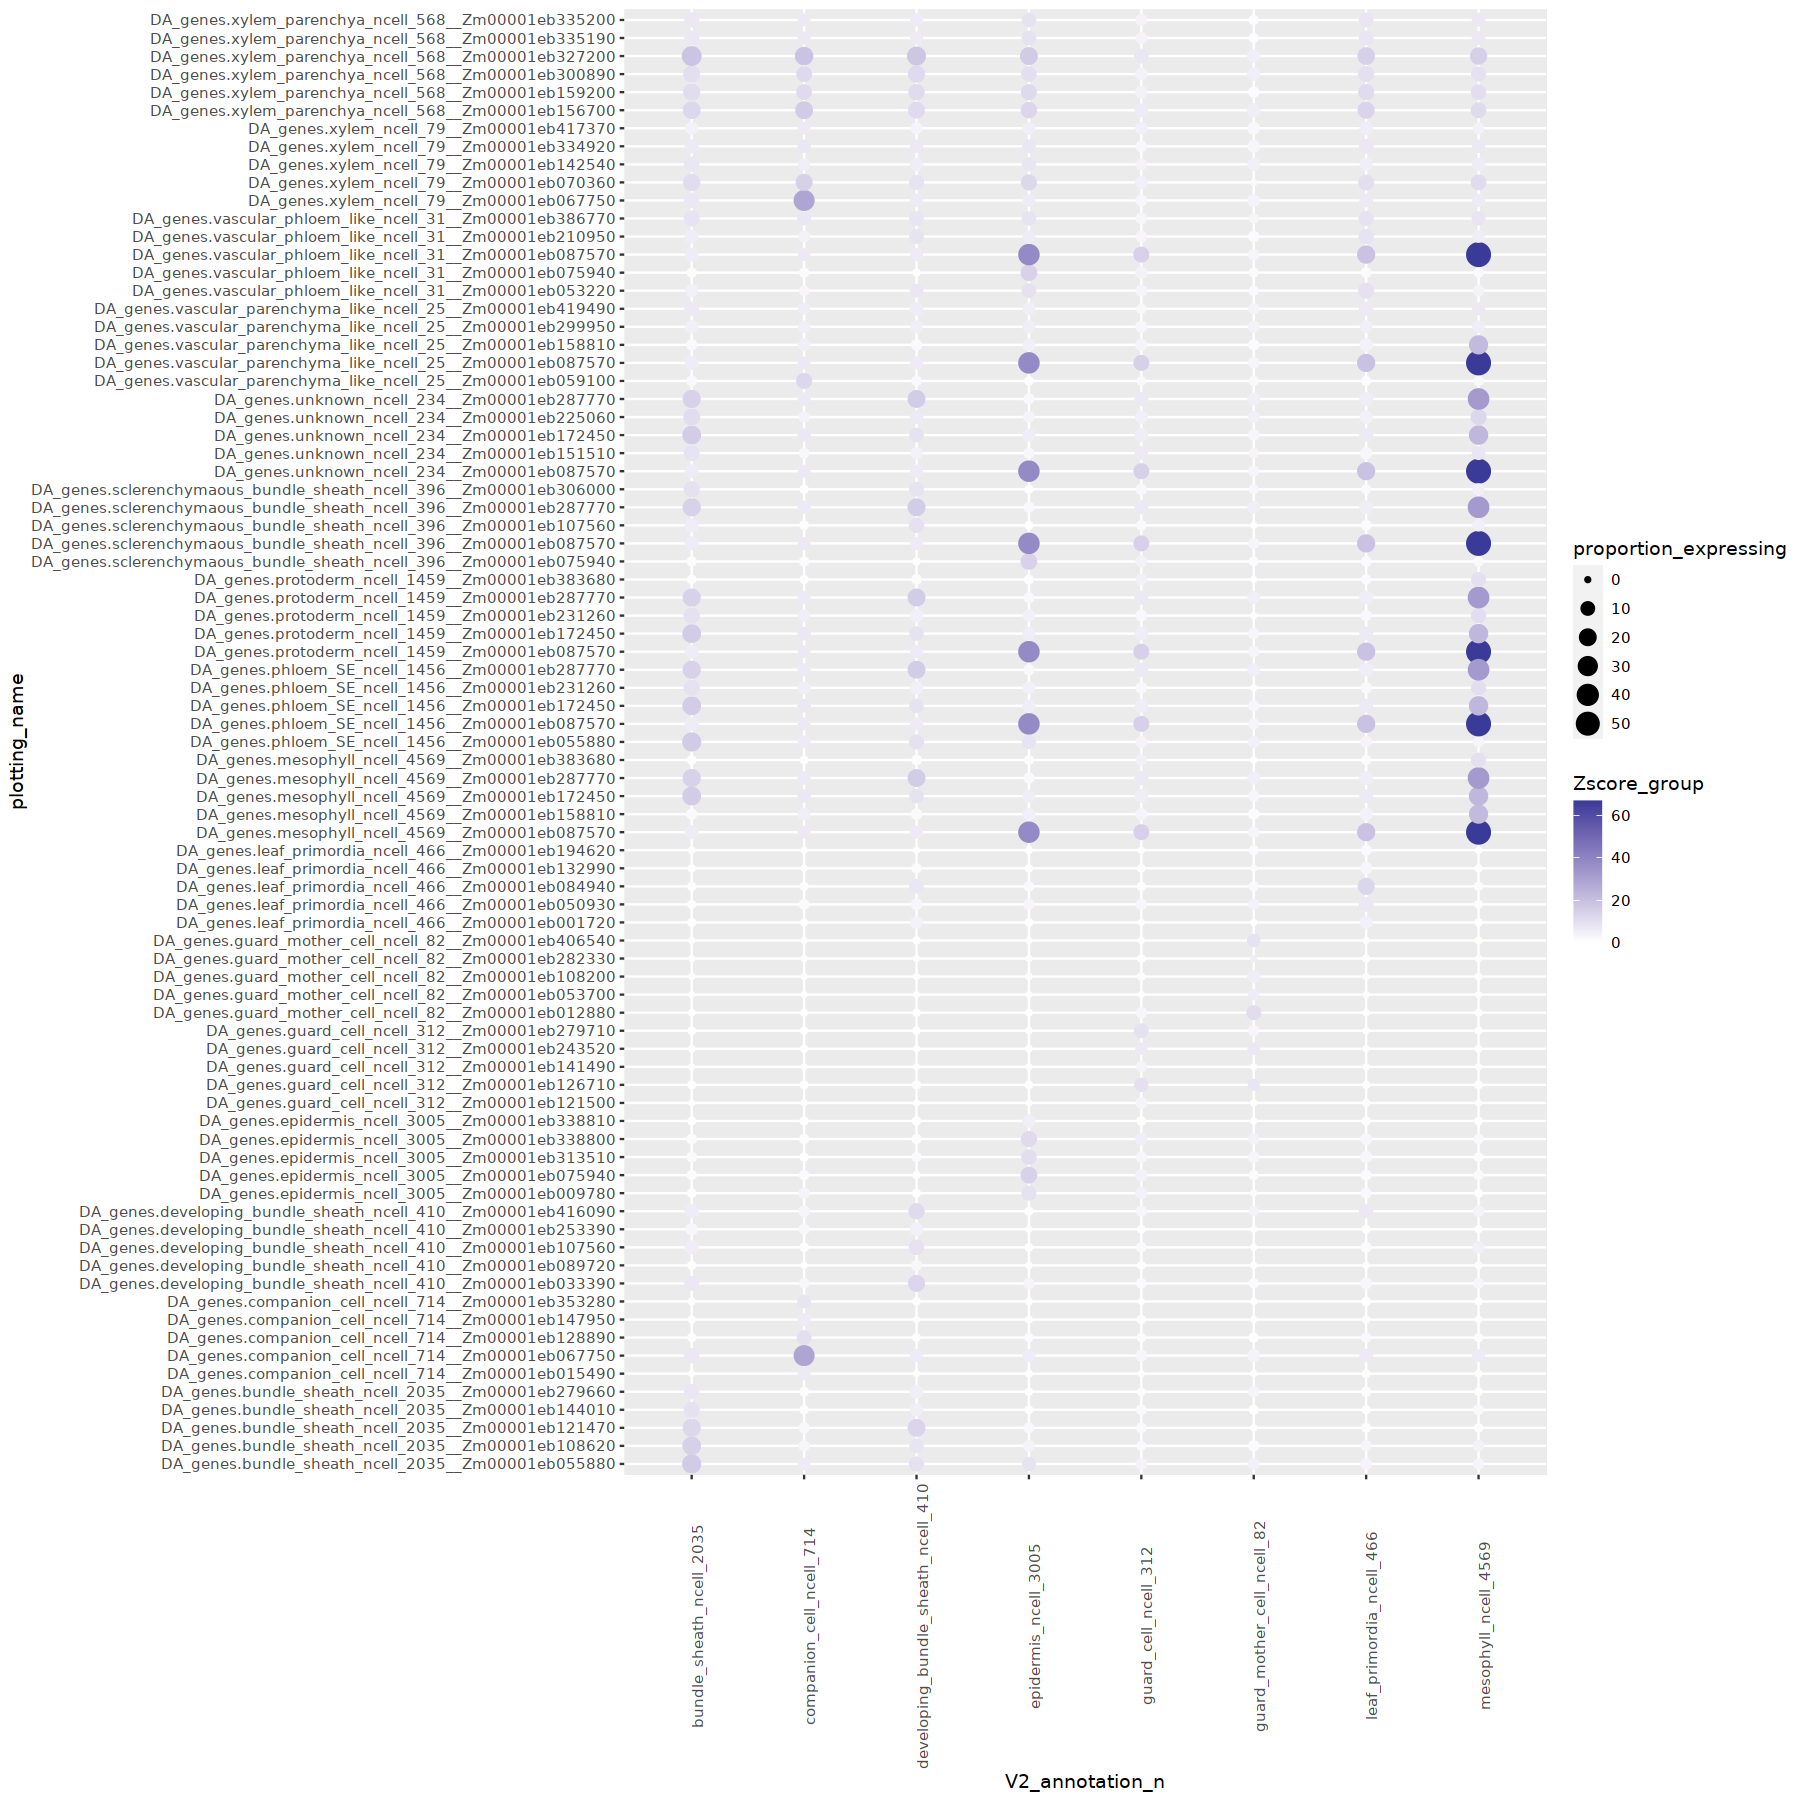

In [13]:
library(viridis)
library(repr)
options(repr.plot.width=15, repr.plot.height=15)

subset <- c('bundle_sheath_ncell_2035','companion_cell_ncell_714',
            'developing_bundle_sheath_ncell_410','epidermis_ncell_3005',
            'guard_cell_ncell_312','guard_mother_cell_ncell_82',
            'leaf_primordia_ncell_466','mesophyll_ncell_4569')
final_plotting_dot %>% 
    filter(V2_annotation_n %in% subset)  %>% 
    ggplot(., aes(x=V2_annotation_n, y = plotting_name, 
                               color = Zscore_group, size = proportion_expressing)) + 
    geom_point() + theme(axis.text.x = element_text(angle = 90)) + scale_colour_gradient2()

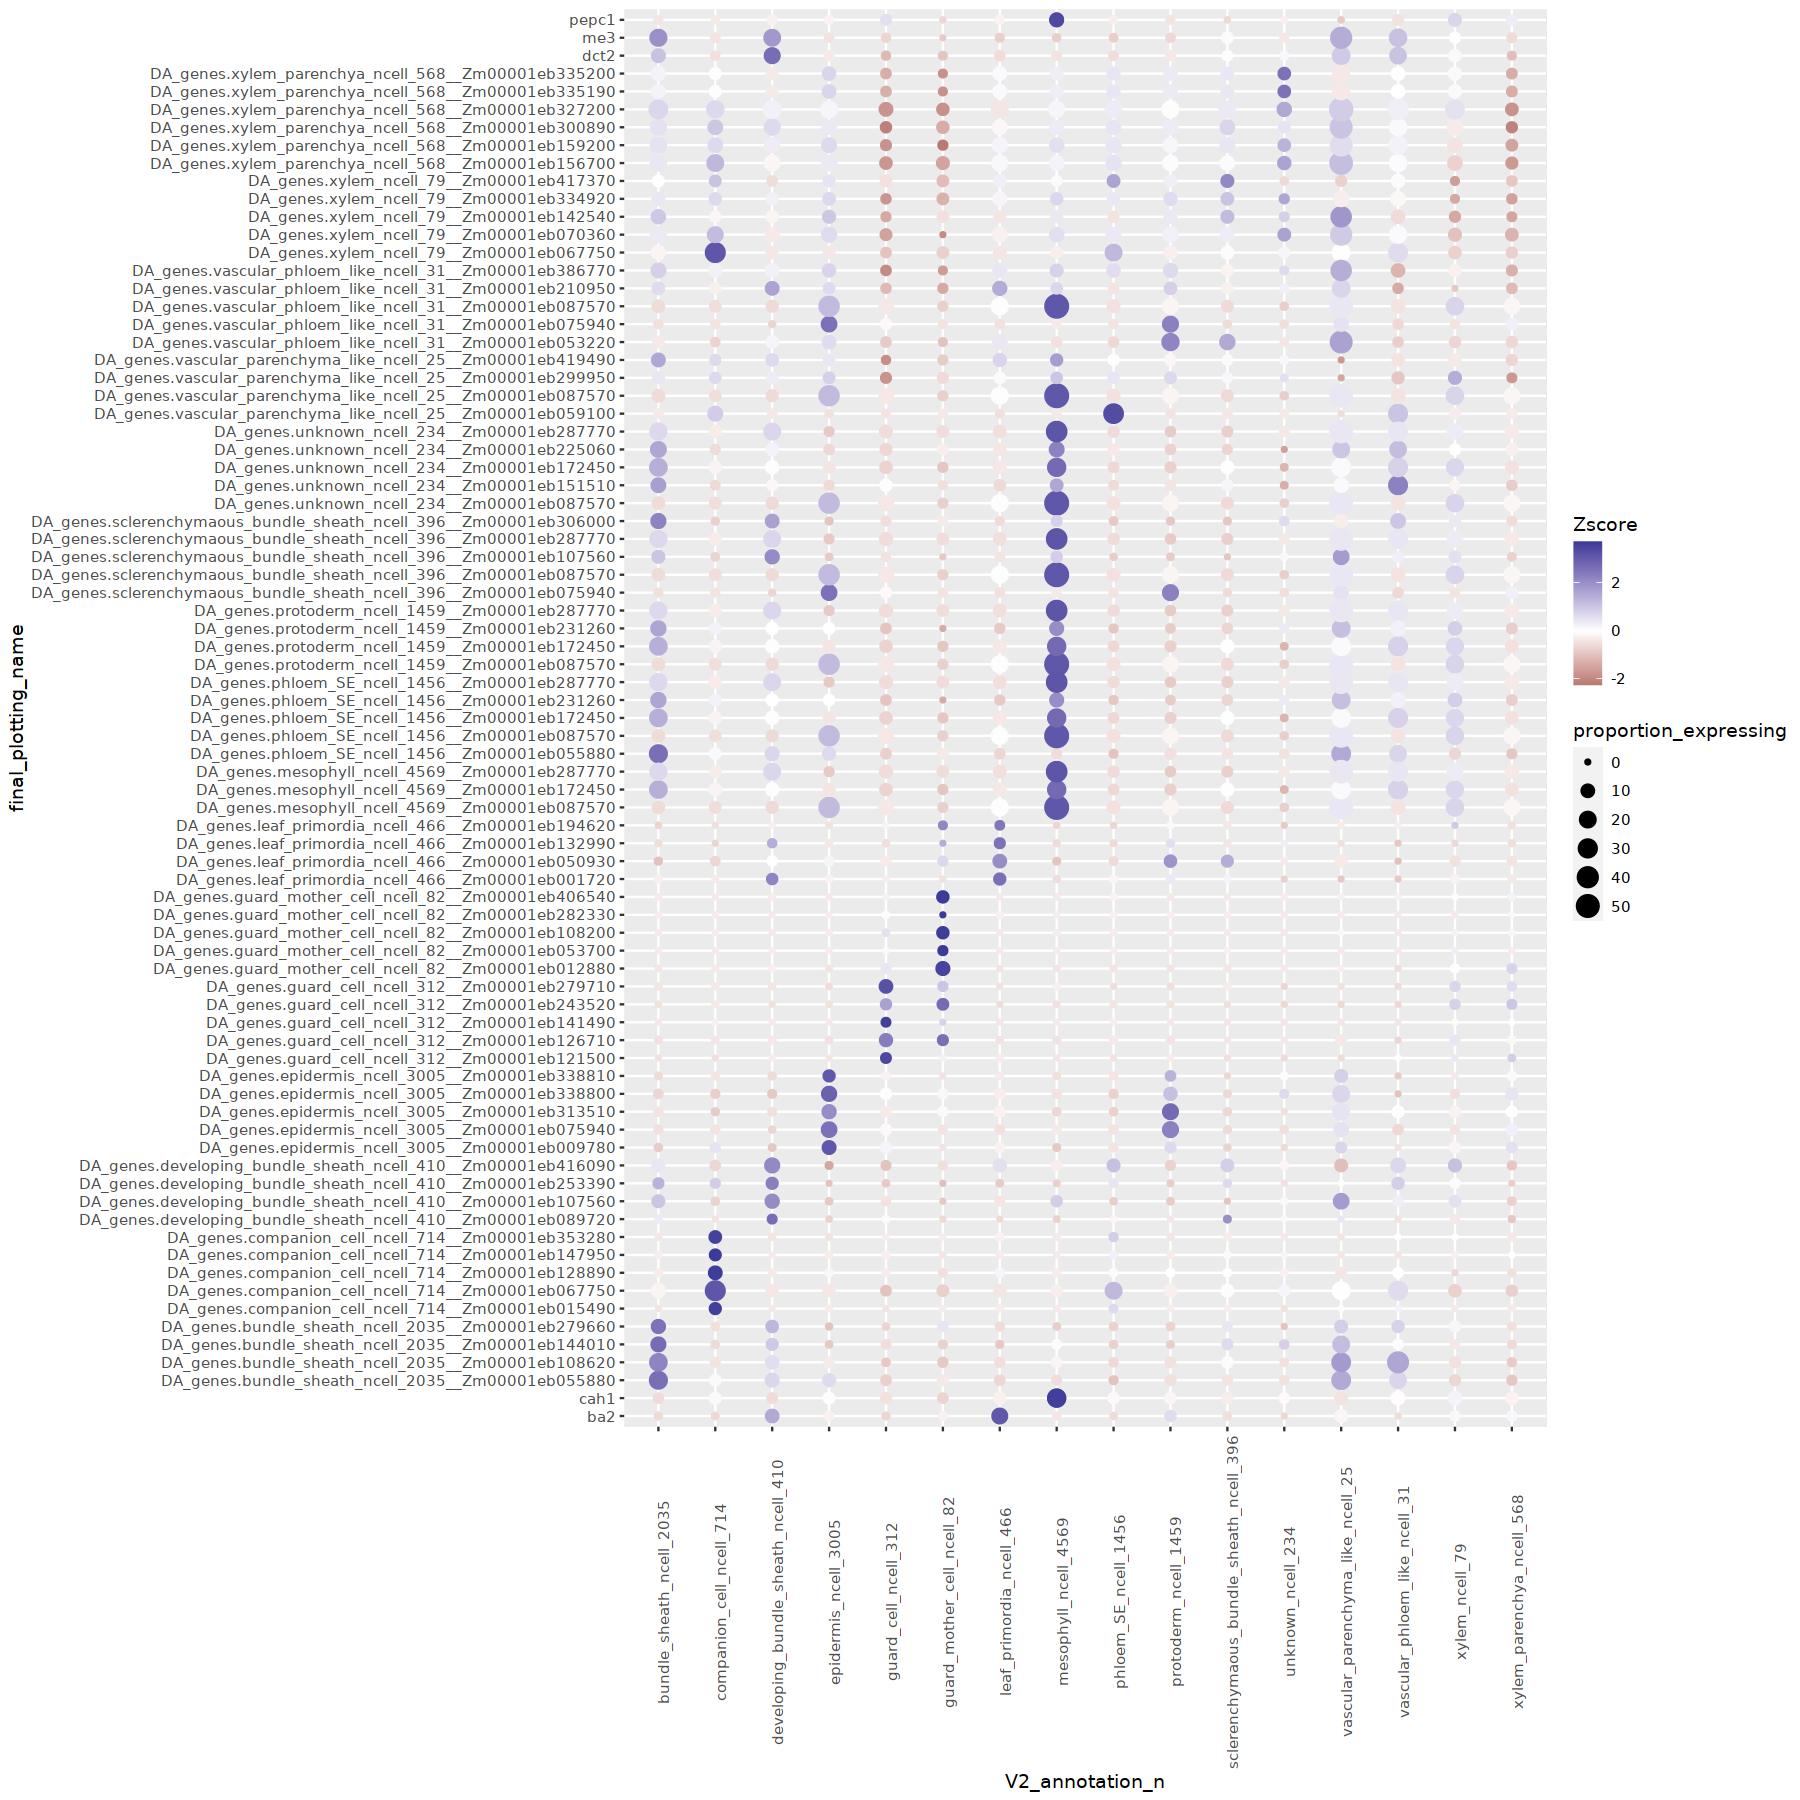

In [14]:
combined_plot_markers <- left_join(final_plotting_dot, gene_markers, by = "geneID")  %>% 
    mutate(final_plotting_name = case_when(is.na(name) != TRUE ~ name,
                                          is.na(name) == TRUE ~plotting_name))

options(repr.plot.width=15, repr.plot.height=15)
ggplot(combined_plot_markers, aes(x=V2_annotation_n, y = final_plotting_name, 
                               color = Zscore, size = proportion_expressing)) + 
    geom_point() + theme(axis.text.x = element_text(angle = 90)) + scale_colour_gradient2()

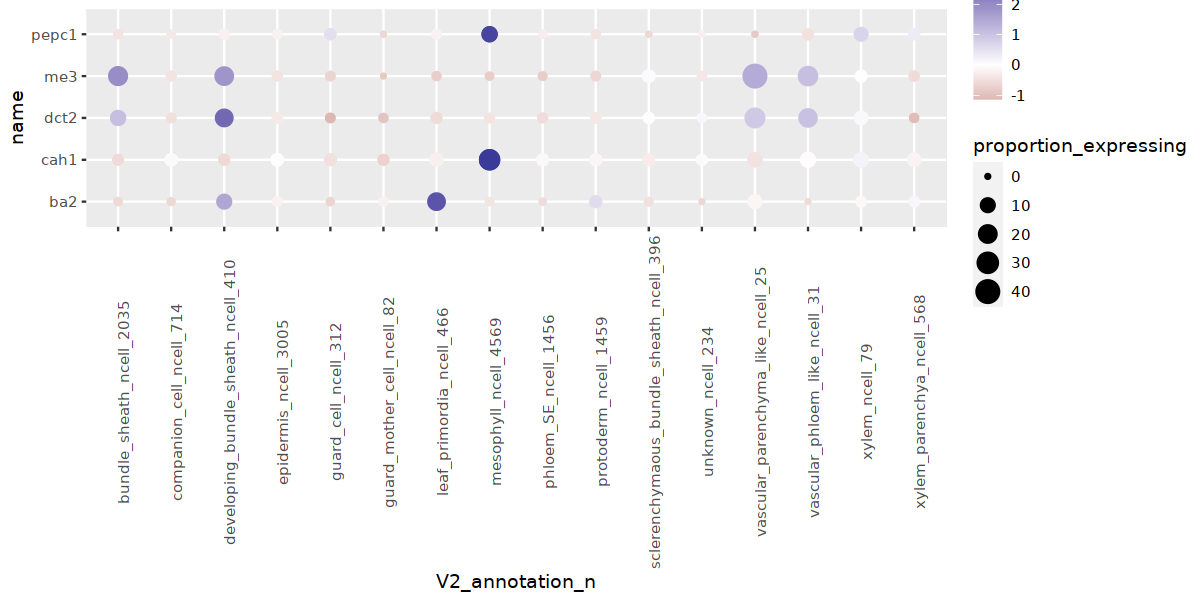

In [15]:
options(repr.plot.width=10, repr.plot.height=5)

combined_plot_markers  %>% 
    filter(is.na(name)!= TRUE)  %>% 
    ggplot(., aes(x=V2_annotation_n, y = name, 
                               color = Zscore, size = proportion_expressing)) + 
    geom_point() + theme(axis.text.x = element_text(angle = 90)) + scale_colour_gradient2()

In [16]:
log2fc_values <- merge_values  %>% 
    group_by(origin) %>% 
    arrange(log2FoldChange) %>% 
    head(5)
    

## Dot Plot For Just Marker Genes

In [17]:
cell_accessability_markers <- merged_meta_cpm_information_copied %>% 
    dplyr::select(-counts) %>% 
    pivot_wider(names_from = geneID, values_from = grouped_CPM, values_fill = 0) %>% 
    pivot_longer(cols = -V2_annotation_n, names_to = "geneID", values_to = "grouped_CPM") %>% 
    group_by(geneID) %>% 
    mutate(Zscore = scale(grouped_CPM)) %>% 
    #mutate(relative_accessability = rescale(Zscore, to = c(0,1))) %>% 
    filter(geneID %in% all_markers) 
    
    

# Create Proportion Cells Accessible Metrics ------------------------------
merged_meta_cellID_values <- left_join(meta_data, raw_cpm_counts_all_genes, by = c("cellID"))
take_unq_genes <- unique(merged_meta_cellID_values$geneID)


merged_meta_cellID_values_all_genes <- merged_meta_cellID_values %>% 
    select(cellID, V2_annotation_n, accessability, geneID) 


colnames(merged_meta_cellID_values_all_genes)
colnames(merged_meta_cellID_values_all_genes)

cell_accessability_wider_all_genes <- merged_meta_cellID_values_all_genes %>% 
                    filter(geneID %in% all_markers) %>% 
                    pivot_wider(names_from = geneID, 
                                values_from = accessability,  
                                values_fill = 0) %>% 
                    pivot_longer(cols = c(-V2_annotation_n, -cellID), 
                                 names_to = "geneID", 
                                 values_to = "accessability") %>% 
                    mutate(expression_bool = case_when(accessability <= 2 ~ 0,
                                                       accessability > 2 ~ 1)) %>% 
                    group_by(V2_annotation_n, geneID) %>% 
                    summarise(total_cells = n(), 
                              proportion_expressing = (sum(expression_bool)/total_cells * 100))


colnames(merged_meta_cellID_values_all_genes)
merged_meta_cellID_values_all_genes %>% 
    group_by(V2_annotation_n) %>% 
    select(-accessability, -cellID) %>% 
    unique() %>% 
    summarise(count = n())

[1] "cellID"          "V2_annotation_n" "accessability"   "geneID"

[1] "cellID"          "V2_annotation_n" "accessability"   "geneID"

`summarise()` has grouped output by 'V2_annotation_n'. You can override using the `.groups` argument.


[1] "cellID"          "V2_annotation_n" "accessability"   "geneID"

V2_annotation_n                         count
1  bundle_sheath_ncell_2035                35435
2  companion_cell_ncell_714                32211
3  developing_bundle_sheath_ncell_410      31144
4  epidermis_ncell_3005                    35831
5  guard_cell_ncell_312                    32315
6  guard_mother_cell_ncell_82              22027
7  leaf_primordia_ncell_466                32104
8  mesophyll_ncell_4569                    36531
9  phloem_SE_ncell_1456                    34418
10 protoderm_ncell_1459                    34606
11 sclerenchymaous_bundle_sheath_ncell_396 29773
12 unknown_ncell_234                       21944
13 vascular_parenchyma_like_ncell_25       18814
14 vascular_phloem_like_ncell_31           18528
15 xylem_ncell_79                          24032
16 xylem_parenchya_ncell_568               31585

In [18]:
marker_final_plotting <- left_join(cell_accessability_markers, cell_accessability_wider_all_genes, by = c("V2_annotation_n", "geneID")) %>% 
        left_join(., gene_markers, by = c("geneID"))

In [19]:
head(test_marker_clust)

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'head': object 'test_marker_clust' not found


In [ ]:
marker_final_plotting

In [ ]:
test_marker_clust <- marker_final_plotting  %>% 
    ungroup() %>% 
    dplyr::select(V2_annotation_n, Zscore, name)  %>% 
    pivot_wider(names_from = V2_annotation_n, values_from = Zscore) %>% 
      data.frame() # make df as tibbles -> matrix annoying

row.names(test_marker_clust) <- test_marker_clust$name  # put gene in `row`
test_marker_clust <- test_marker_clust[,-1] #drop gene column as now in rows
clust <- hclust(dist(test_marker_clust %>% as.matrix())) # hclust with distance matrix

In [ ]:
mat <- marker_final_plotting %>% 
    ungroup() %>% 
    dplyr::select(V2_annotation_n, Zscore, name)  %>% 
    pivot_wider(names_from = V2_annotation_n, values_from = Zscore) %>% 
      data.frame() # make df as tibbles -> matrix annoying
row.names(mat) <- mat$name  # put gene in `row`
mat <- mat[,-1] #drop gene column as now in rows
v_clust <- hclust(dist(mat %>% as.matrix() %>% t())) # hclust with distance matrix

In [ ]:
clust$labels[clust$order]

In [ ]:
options(repr.plot.width=10, repr.plot.height=30)

marker_final_plotting  %>% 
    mutate(Gene_name = factor(name, clust$labels[clust$order]),
          Cluster_name = factor(V2_annotation_n, levels = v_clust$labels[v_clust$order])) %>% 
    ggplot(., aes(x=V2_annotation_n, y = Gene_name, 
                               color = Zscore, size = proportion_expressing)) + 
    geom_point() + theme(axis.text.x = element_text(angle = 90)) + scale_colour_gradient2()

In [ ]:
options(repr.plot.width=10, repr.plot.height=30)

marker_final_plotting  %>% 
    ggplot(., aes(x=V2_annotation_n, y = name, 
                               color = Zscore, size = proportion_expressing)) + 
    geom_point() + theme(axis.text.x = element_text(angle = 90)) + scale_colour_gradient2()

# Log2FC Values

In [ ]:
str(merge_values)

In [ ]:
log2fc_values <- all_merge_values  %>% 
    group_by(origin) %>% 
    slice_min(log2FoldChange, n = 5, with_ties = FALSE)  %>% 
    ungroup()

In [ ]:
log2fc_sorted <- merged_meta_cpm_information_copied %>% 
    dplyr::select(-counts) %>% 
    pivot_wider(names_from = geneID, values_from = grouped_CPM, values_fill = 0) %>% 
    pivot_longer(cols = -V2_annotation_n, names_to = "geneID", values_to = "grouped_CPM") %>% 
    group_by(geneID) %>% 
    mutate(Zscore = scale(grouped_CPM)) %>% 
    ungroup()  %>% 
    #mutate(relative_accessability = rescale(Zscore, to = c(0,1))) %>% 
    group_by(V2_annotation_n)  %>% 
    mutate(Zscore_group = scale(grouped_CPM)) %>% 
    filter(geneID %in% log2fc_values$gene_name)

In [ ]:

# Create Proportion Cells Accessible Metrics ------------------------------
merged_meta_cellID_values <- left_join(meta_data, raw_cpm_counts_all_genes, by = c("cellID"))
take_unq_genes <- unique(merged_meta_cellID_values$geneID)


merged_meta_cellID_values_all_genes <- merged_meta_cellID_values %>% 
    select(cellID, V2_annotation_n, accessability, geneID) 


cell_accessability_wider_all_genes <- merged_meta_cellID_values_all_genes %>% 
                    filter(geneID %in% log2fc_values$gene_name) %>% 
                    pivot_wider(names_from = geneID, 
                                values_from = accessability,  
                                values_fill = 0) %>% 
                    pivot_longer(cols = c(-V2_annotation_n, -cellID), 
                                 names_to = "geneID", 
                                 values_to = "accessability") %>% 
                    mutate(expression_bool = case_when(accessability <= 2 ~ 0,
                                                       accessability > 2 ~ 1)) %>% 
                    group_by(V2_annotation_n, geneID) %>% 
                    summarise(total_cells = n(), 
                              proportion_expressing = (sum(expression_bool)/total_cells * 100))

In [ ]:


log2fc_genes <-  left_join(log2fc_sorted, cell_accessability_wider_all_genes, by = c("V2_annotation_n", "geneID")) %>% 
        left_join(., log2fc_values, by = c("geneID" = "gene_name")) %>% 
        mutate(plotting_name = str_c(origin,geneID, sep = "__"))



options(repr.plot.width=10, repr.plot.height=15)
ggplot(log2fc_genes, aes(x=V2_annotation_n, y = plotting_name, 
                               color = Zscore, size = proportion_expressing)) + 
    geom_point() + theme(axis.text.x = element_text(angle = 90)) + scale_colour_gradient2()

# Updated DEseq2

In [3]:
file_names_altered <- c("zea.V2_annot.equal_cell_pops/zea_mays.annotation_V2.DA_genes.bundle_sheath_ncell_2035.NA.cluster_specific.tsv",
"zea.V2_annot.equal_cell_pops/zea_mays.annotation_V2.DA_genes.companion_cell_ncell_714.NA.cluster_specific.tsv",
"zea.V2_annot.equal_cell_pops/zea_mays.annotation_V2.DA_genes.developing_bundle_sheath_ncell_410.NA.cluster_specific.tsv",
"zea.V2_annot.equal_cell_pops/zea_mays.annotation_V2.DA_genes.epidermis_ncell_3005.NA.cluster_specific.tsv",
"zea.V2_annot.equal_cell_pops/zea_mays.annotation_V2.DA_genes.guard_cell_ncell_312.NA.cluster_specific.tsv",
"zea.V2_annot.equal_cell_pops/zea_mays.annotation_V2.DA_genes.guard_mother_cell_ncell_82.NA.cluster_specific.tsv",
"zea.V2_annot.equal_cell_pops/zea_mays.annotation_V2.DA_genes.leaf_primordia_ncell_466.NA.cluster_specific.tsv",
"zea.V2_annot.equal_cell_pops/zea_mays.annotation_V2.DA_genes.mesophyll_ncell_4569.NA.cluster_specific.tsv",
"zea.V2_annot.equal_cell_pops/zea_mays.annotation_V2.DA_genes.phloem_SE_ncell_1456.NA.cluster_specific.tsv",
"zea.V2_annot.equal_cell_pops/zea_mays.annotation_V2.DA_genes.protoderm_ncell_1459.NA.cluster_specific.tsv",
"zea.V2_annot.equal_cell_pops/zea_mays.annotation_V2.DA_genes.sclerenchymaous_bundle_sheath_ncell_396.NA.cluster_specific.tsv",
"zea.V2_annot.equal_cell_pops/zea_mays.annotation_V2.DA_genes.unknown_ncell_234.NA.cluster_specific.tsv",
"zea.V2_annot.equal_cell_pops/zea_mays.annotation_V2.DA_genes.vascular_parenchyma_like_ncell_25.NA.cluster_specific.tsv",
"zea.V2_annot.equal_cell_pops/zea_mays.annotation_V2.DA_genes.vascular_phloem_like_ncell_31.NA.cluster_specific.tsv",
"zea.V2_annot.equal_cell_pops/zea_mays.annotation_V2.DA_genes.xylem_ncell_79.NA.cluster_specific.tsv",
"zea.V2_annot.equal_cell_pops/zea_mays.annotation_V2.DA_genes.xylem_parenchya_ncell_568.NA.cluster_specific.tsv")

read_DA_genes_altered <- function( file_name){
    
    working_dir <- "/scratch/jpm73279/comparative_single_cell/08.annotation_figures/zea_mays"
    replace_name <- paste0(working_dir, "/zea.V2_annot/zea_mays.annotation_V2.")
    filtered <- read_tsv(here(working_dir,file_name), col_names = TRUE,id = "origin")  %>% 
        mutate(origin = str_replace(origin, "/scratch/jpm73279/comparative_single_cell/08.annotation_figures/zea_mays/zea.V2_annot.equal_cell_pops/zea_mays.annotation_V2.", ""))  %>% 
        mutate(origin = str_replace(origin, ".NA.cluster_specific.tsv", ""))  %>% 
        filter(padj < .05)
    
    return(filtered)    
}

read_all_DA_genes_altered <- lapply(file_names_altered, read_DA_genes_altered)
all_merge_values_altered <- data.table::rbindlist(read_all_DA_genes_altered)

Rows: 3689 Columns: 8
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): gene_name
dbl (6): baseMean, log2FoldChange, lfcSE, stat, pvalue, padj

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1557 Columns: 8
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): gene_name
dbl (6): baseMean, log2FoldChange, lfcSE, stat, pvalue, padj

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 801 Columns: 8
── Column specification ───────────────────────────────────────────────────────────────────────────

Rows: 1948 Columns: 8
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): gene_name
dbl (6): baseMean, log2FoldChange, lfcSE, stat, pvalue, padj

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
head(all_merge_values_altered)

origin                            gene_name       baseMean  log2FoldChange
1 DA_genes.bundle_sheath_ncell_2035 Zm00001eb121470 1252.7079 -1.807875     
2 DA_genes.bundle_sheath_ncell_2035 Zm00001eb055880 1708.8992 -1.394260     
3 DA_genes.bundle_sheath_ncell_2035 Zm00001eb108620 1526.4381 -1.431355     
4 DA_genes.bundle_sheath_ncell_2035 Zm00001eb144010  943.6643 -1.751462     
5 DA_genes.bundle_sheath_ncell_2035 Zm00001eb279660  765.5335 -2.039102     
6 DA_genes.bundle_sheath_ncell_2035 Zm00001eb432510  901.5842 -1.507363     
  lfcSE      stat      pvalue       padj        
1 0.09237153 -19.57177 2.691497e-85 7.503087e-81
2 0.07550858 -18.46492 3.956319e-76 5.514515e-72
3 0.08289538 -17.26700 8.335949e-67 7.746042e-63
4 0.10625358 -16.48379 4.798134e-61 3.343940e-57
5 0.12420887 -16.41672 1.452014e-60 8.095558e-57
6 0.10421956 -14.46334 2.065193e-47 9.595233e-44

In [5]:
merge_values_altered <- all_merge_values_altered %>% 
    group_by(origin) %>% 
    slice_min(padj, n =5)

    


head(merged_meta_cpm_information_copied)
altered_deseq2 <- merged_meta_cpm_information_copied %>% 
    dplyr::select(-counts) %>% 
    pivot_wider(names_from = geneID, values_from = grouped_CPM, values_fill = 0) %>% 
    pivot_longer(cols = -V2_annotation_n, names_to = "geneID", values_to = "grouped_CPM") %>% 
    group_by(geneID) %>% 
    mutate(Zscore = scale(grouped_CPM)) %>% 
    ungroup()  %>% 
    #mutate(relative_accessability = rescale(Zscore, to = c(0,1))) %>% 
    group_by(V2_annotation_n)  %>% 
    mutate(Zscore_group = scale(grouped_CPM)) %>% 
    filter(geneID %in% merge_values_altered$gene_name)


# Create Proportion Cells Accessible Metrics ------------------------------
merged_meta_cellID_values <- left_join(meta_data, raw_cpm_counts_all_genes, by = c("cellID"))
take_unq_genes <- unique(merged_meta_cellID_values$geneID)


merged_meta_cellID_values_all_genes <- merged_meta_cellID_values %>% 
    select(cellID, V2_annotation_n, accessability, geneID) 


colnames(merged_meta_cellID_values_all_genes)
colnames(merged_meta_cellID_values_all_genes)

wider_all_genes_altered <- merged_meta_cellID_values_all_genes %>% 
                    filter(geneID %in% merge_values_altered$gene_name) %>% 
                    pivot_wider(names_from = geneID, 
                                values_from = accessability,  
                                values_fill = 0) %>% 
                    pivot_longer(cols = c(-V2_annotation_n, -cellID), 
                                 names_to = "geneID", 
                                 values_to = "accessability") %>% 
                    mutate(expression_bool = case_when(accessability <= 2 ~ 0,
                                                       accessability > 2 ~ 1)) %>% 
                    group_by(V2_annotation_n, geneID) %>% 
                    summarise(total_cells = n(), 
                              proportion_expressing = (sum(expression_bool)/total_cells * 100))


colnames(merged_meta_cellID_values_all_genes)
merged_meta_cellID_values_all_genes %>% 
    group_by(V2_annotation_n) %>% 
    select(-accessability, -cellID) %>% 
    unique() %>% 
    summarise(count = n())

V2_annotation_n          geneID          counts grouped_CPM
1 bundle_sheath_ncell_2035 Zm00001eb000010  65    11.8368798 
2 bundle_sheath_ncell_2035 Zm00001eb000020  14     2.5494818 
3 bundle_sheath_ncell_2035 Zm00001eb000050   2     0.3642117 
4 bundle_sheath_ncell_2035 Zm00001eb000060  96    17.4821609 
5 bundle_sheath_ncell_2035 Zm00001eb000070  60    10.9263506 
6 bundle_sheath_ncell_2035 Zm00001eb000080 235    42.7948731

[1] "cellID"          "V2_annotation_n" "accessability"   "geneID"

[1] "cellID"          "V2_annotation_n" "accessability"   "geneID"

`summarise()` has grouped output by 'V2_annotation_n'. You can override using the `.groups` argument.


[1] "cellID"          "V2_annotation_n" "accessability"   "geneID"

V2_annotation_n                         count
1  bundle_sheath_ncell_2035                35435
2  companion_cell_ncell_714                32211
3  developing_bundle_sheath_ncell_410      31144
4  epidermis_ncell_3005                    35831
5  guard_cell_ncell_312                    32315
6  guard_mother_cell_ncell_82              22027
7  leaf_primordia_ncell_466                32104
8  mesophyll_ncell_4569                    36531
9  phloem_SE_ncell_1456                    34418
10 protoderm_ncell_1459                    34606
11 sclerenchymaous_bundle_sheath_ncell_396 29773
12 unknown_ncell_234                       21944
13 vascular_parenchyma_like_ncell_25       18814
14 vascular_phloem_like_ncell_31           18528
15 xylem_ncell_79                          24032
16 xylem_parenchya_ncell_568               31585

In [6]:
final_plotting_dot <- left_join(altered_deseq2, wider_all_genes_altered, by = c("V2_annotation_n", "geneID")) %>% 
        left_join(., merge_values_altered, by = c("geneID" = "gene_name")) %>% 
        mutate(plotting_name = str_c(origin,geneID, sep = "__"))

In [7]:
unique(final_plotting_dot$V2_annotation_n)

[1] "bundle_sheath_ncell_2035"               
 [2] "companion_cell_ncell_714"               
 [3] "developing_bundle_sheath_ncell_410"     
 [4] "epidermis_ncell_3005"                   
 [5] "guard_cell_ncell_312"                   
 [6] "guard_mother_cell_ncell_82"             
 [7] "leaf_primordia_ncell_466"               
 [8] "mesophyll_ncell_4569"                   
 [9] "phloem_SE_ncell_1456"                   
[10] "protoderm_ncell_1459"                   
[11] "sclerenchymaous_bundle_sheath_ncell_396"
[12] "unknown_ncell_234"                      
[13] "vascular_parenchyma_like_ncell_25"      
[14] "vascular_phloem_like_ncell_31"          
[15] "xylem_ncell_79"                         
[16] "xylem_parenchya_ncell_568"

In [15]:
final_plotting_dot

V2_annotation_n           geneID          grouped_CPM Zscore     
1    bundle_sheath_ncell_2035  Zm00001eb000690 242.0186651  0.5604593 
2    bundle_sheath_ncell_2035  Zm00001eb008930 353.6495468  0.4952930 
3    bundle_sheath_ncell_2035  Zm00001eb009780  50.2612126 -0.8352318 
4    bundle_sheath_ncell_2035  Zm00001eb012880  15.2968908 -0.4018181 
5    bundle_sheath_ncell_2035  Zm00001eb033390 353.8316526  1.0875997 
6    bundle_sheath_ncell_2035  Zm00001eb034260 322.8736593  1.8316473 
7    bundle_sheath_ncell_2035  Zm00001eb034840  59.0022931 -0.4967688 
8    bundle_sheath_ncell_2035  Zm00001eb046350  17.1179492 -0.3009116 
9    bundle_sheath_ncell_2035  Zm00001eb053700   0.3642117 -0.3277220 
10   bundle_sheath_ncell_2035  Zm00001eb055880 766.8477042  2.6266208 
11   bundle_sheath_ncell_2035  Zm00001eb055880 766.8477042  2.6266208 
12   bundle_sheath_ncell_2035  Zm00001eb067750 348.7326890 -0.1743632 
13   bundle_sheath_ncell_2035  Zm00001eb075940  75.0276072 -0.5070997 
14   bundle_sheath_ncell_2035  Zm00001eb084940  52.4464827 -0.6006454 
15   bundle_sheath_ncell_2035  Zm00001eb087570 299.1998998 -0.5787951 
16   bundle_sheath_ncell_2035  Zm00001eb087570 299.1998998 -0.5787951 
17   bundle_sheath_ncell_2035  Zm00001eb087570 299.1998998 -0.5787951 
18   bundle_sheath_ncell_2035  Zm00001eb087570 299.1998998 -0.5787951 
19   bundle_sheath_ncell_2035  Zm00001eb087570 299.1998998 -0.5787951 
20   bundle_sheath_ncell_2035  Zm00001eb088790 105.2571772 -0.6041732 
21   bundle_sheath_ncell_2035  Zm00001eb107560 274.6156110  1.0328983 
22   bundle_sheath_ncell_2035  Zm00001eb108620 688.3600859  2.2039122 
23   bundle_sheath_ncell_2035  Zm00001eb116150   2.5494818 -0.2933370 
24   bundle_sheath_ncell_2035  Zm00001eb121470 592.0260950  1.9791979 
25   bundle_sheath_ncell_2035  Zm00001eb121470 592.0260950  1.9791979 
26   bundle_sheath_ncell_2035  Zm00001eb126710  37.3316978 -0.4789741 
27   bundle_sheath_ncell_2035  Zm00001eb128890  57.3633405 -0.3117686 
28   bundle_sheath_ncell_2035  Zm00001eb144010 443.2456214  2.6816913 
29   bundle_sheath_ncell_2035  Zm00001eb147950  10.3800330 -0.2742517 
30   bundle_sheath_ncell_2035  Zm00001eb147960  14.3863616 -0.2911564 
⋮    ⋮                         ⋮               ⋮           ⋮          
1059 xylem_parenchya_ncell_568 Zm00001eb194620  10.626057  -0.50830684
1060 xylem_parenchya_ncell_568 Zm00001eb225060 231.496240  -0.25220105
1061 xylem_parenchya_ncell_568 Zm00001eb231260 116.886626  -0.79537722
1062 xylem_parenchya_ncell_568 Zm00001eb231260 116.886626  -0.79537722
1063 xylem_parenchya_ncell_568 Zm00001eb231270 108.537581  -0.59166767
1064 xylem_parenchya_ncell_568 Zm00001eb246090 184.437988   0.22262733
1065 xylem_parenchya_ncell_568 Zm00001eb253390  16.698089  -0.79681676
1066 xylem_parenchya_ncell_568 Zm00001eb253400   8.349045  -0.85095891
1067 xylem_parenchya_ncell_568 Zm00001eb275250  79.695427  -0.68214444
1068 xylem_parenchya_ncell_568 Zm00001eb279660  71.346382  -0.51310646
1069 xylem_parenchya_ncell_568 Zm00001eb279710 101.706545   0.61483862
1070 xylem_parenchya_ncell_568 Zm00001eb282330  28.842154   0.13761893
1071 xylem_parenchya_ncell_568 Zm00001eb287770 306.637642  -0.34427310
1072 xylem_parenchya_ncell_568 Zm00001eb287770 306.637642  -0.34427310
1073 xylem_parenchya_ncell_568 Zm00001eb287770 306.637642  -0.34427310
1074 xylem_parenchya_ncell_568 Zm00001eb287770 306.637642  -0.34427310
1075 xylem_parenchya_ncell_568 Zm00001eb303110  68.310366  -0.16595841
1076 xylem_parenchya_ncell_568 Zm00001eb305960  98.670528  -0.01966849
1077 xylem_parenchya_ncell_568 Zm00001eb319590  53.130285  -1.62152059
1078 xylem_parenchya_ncell_568 Zm00001eb325230  24.288130  -0.32865439
1079 xylem_parenchya_ncell_568 Zm00001eb327200 241.363293  -1.82329122
1080 xylem_parenchya_ncell_568 Zm00001eb338800 228.460224   0.44318468
1081 xylem_parenchya_ncell_568 Zm00001eb340760 144.210772   1.09170550
1082 xylem_parenchya_ncell_568 Zm00001eb353280  19.734106  -0.37717154
1083 xylem_parenchya_ncell_56

In [18]:
final_plotting_dot  %>% 
    dplyr::filter(origin == "DA_genes.mesophyll_ncell_4569" & V2_annotation_n == "mesophyll_ncell_4569")  %>% 
    head(., 20)

V2_annotation_n      geneID          grouped_CPM Zscore   Zscore_group
1 mesophyll_ncell_4569 Zm00001eb087570 3172.566    3.108233 66.864386   
2 mesophyll_ncell_4569 Zm00001eb158810 1031.049    3.614296 21.355786   
3 mesophyll_ncell_4569 Zm00001eb172450 1095.137    2.719904 22.717688   
4 mesophyll_ncell_4569 Zm00001eb287770 1545.018    3.148380 32.277948   
5 mesophyll_ncell_4569 Zm00001eb383680  474.202    3.389055  9.522423   
  total_cells proportion_expressing origin                        baseMean 
1 4497        56.57105              DA_genes.mesophyll_ncell_4569 12861.680
2 4497        25.61708              DA_genes.mesophyll_ncell_4569  4120.283
3 4497        26.30643              DA_genes.mesophyll_ncell_4569  4629.039
4 4497        37.24705              DA_genes.mesophyll_ncell_4569  6226.828
5 4497        10.42918              DA_genes.mesophyll_ncell_4569  1867.281
  log2FoldChange lfcSE      stat      pvalue        padj         
1 -1.401500      0.02683156 -52.23325  0.000000e+00  0.000000e+00
2 -1.507620      0.04782919 -31.52093 4.489246e-218 4.300548e-214
3 -1.123739      0.04266469 -26.33885 6.887323e-153 4.948369e-149
4 -1.443670      0.03854870 -37.45055 5.883645e-292 8.454504e-292
5 -1.618916      0.07032314 -23.02109 2.866147e-117 1.647404e-113
  plotting_name                                 
1 DA_genes.mesophyll_ncell_4569__Zm00001eb087570
2 DA_genes.mesophyll_ncell_4569__Zm00001eb158810
3 DA_genes.mesophyll_ncell_4569__Zm00001eb172450
4 DA_genes.mesophyll_ncell_4569__Zm00001eb287770
5 DA_genes.mesophyll_ncell_4569__Zm00001eb383680

In [9]:
library(viridis)
library(repr)
options(repr.plot.width=15, repr.plot.height=13)
library(cowplot)

zm_dot <- ggplot(final_plotting_dot, aes(x=V2_annotation_n, y = plotting_name, 
                               color = Zscore, size = proportion_expressing)) + 
    theme_cowplot() +
    geom_point() + theme(axis.text.x = element_text(angle = 90)) + scale_colour_gradient2() +
    theme(axis.text.x = element_text(size = 15),
         axis.text.y = element_text(size = 10)) +  coord_flip()


Loading required package: viridisLite



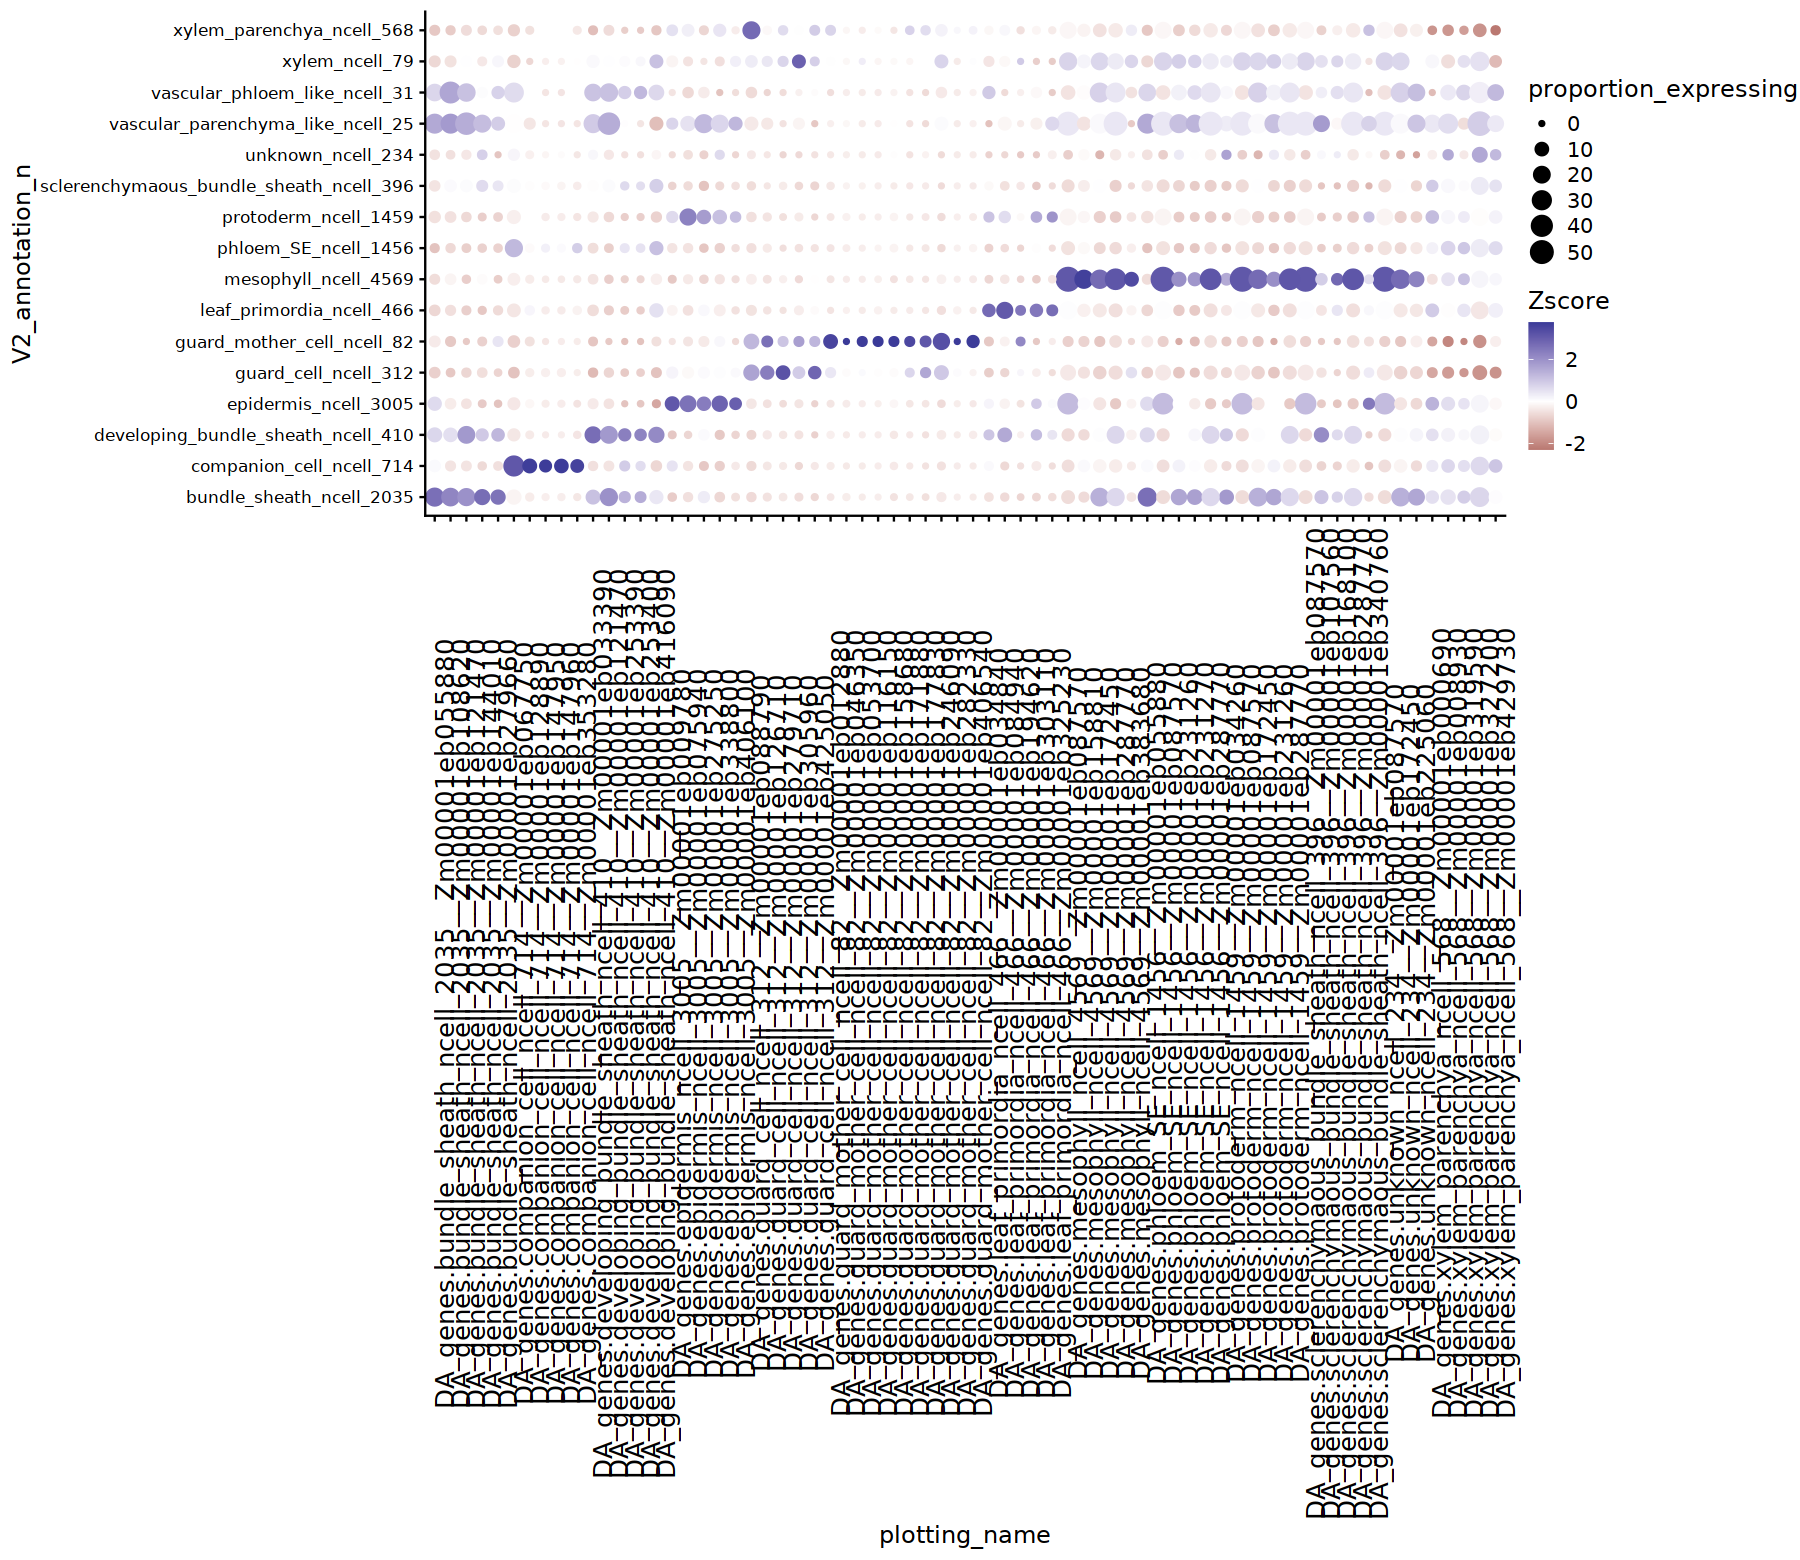

In [71]:
zm_dot

In [72]:
ggsave("zm.annot_dotplot.pdf",
      plot = zm_dot,
      path = "/home/jpm73279/EvoChromo_poster",
       units = "in",
       width = 15, height = 13)

In [25]:

## Just Markers
altered_deseq2 <- merged_meta_cpm_information_copied %>% 
    dplyr::select(-counts) %>% 
    pivot_wider(names_from = geneID, values_from = grouped_CPM, values_fill = 0) %>% 
    pivot_longer(cols = -V2_annotation_n, names_to = "geneID", values_to = "grouped_CPM") %>% 
    group_by(geneID) %>% 
    mutate(Zscore = scale(grouped_CPM)) %>% 
    ungroup()  %>% 
    #mutate(relative_accessability = rescale(Zscore, to = c(0,1))) %>% 
    group_by(V2_annotation_n)  %>% 
    mutate(Zscore_group = scale(grouped_CPM)) %>% 
    filter(geneID %in% all_markers)


wider_all_genes_altered <- merged_meta_cellID_values_all_genes %>% 
                    filter(geneID %in% all_markers)  %>% 
                    pivot_wider(names_from = geneID, 
                                values_from = accessability,  
                                values_fill = 0) %>% 
                    pivot_longer(cols = c(-V2_annotation_n, -cellID), 
                                 names_to = "geneID", 
                                 values_to = "accessability") %>% 
                    mutate(expression_bool = case_when(accessability <= 2 ~ 0,
                                                       accessability > 2 ~ 1)) %>% 
                    group_by(V2_annotation_n, geneID) %>% 
                    summarise(total_cells = n(), 
                              proportion_expressing = (sum(expression_bool)/total_cells * 100))


`summarise()` has grouped output by 'V2_annotation_n'. You can override using the `.groups` argument.


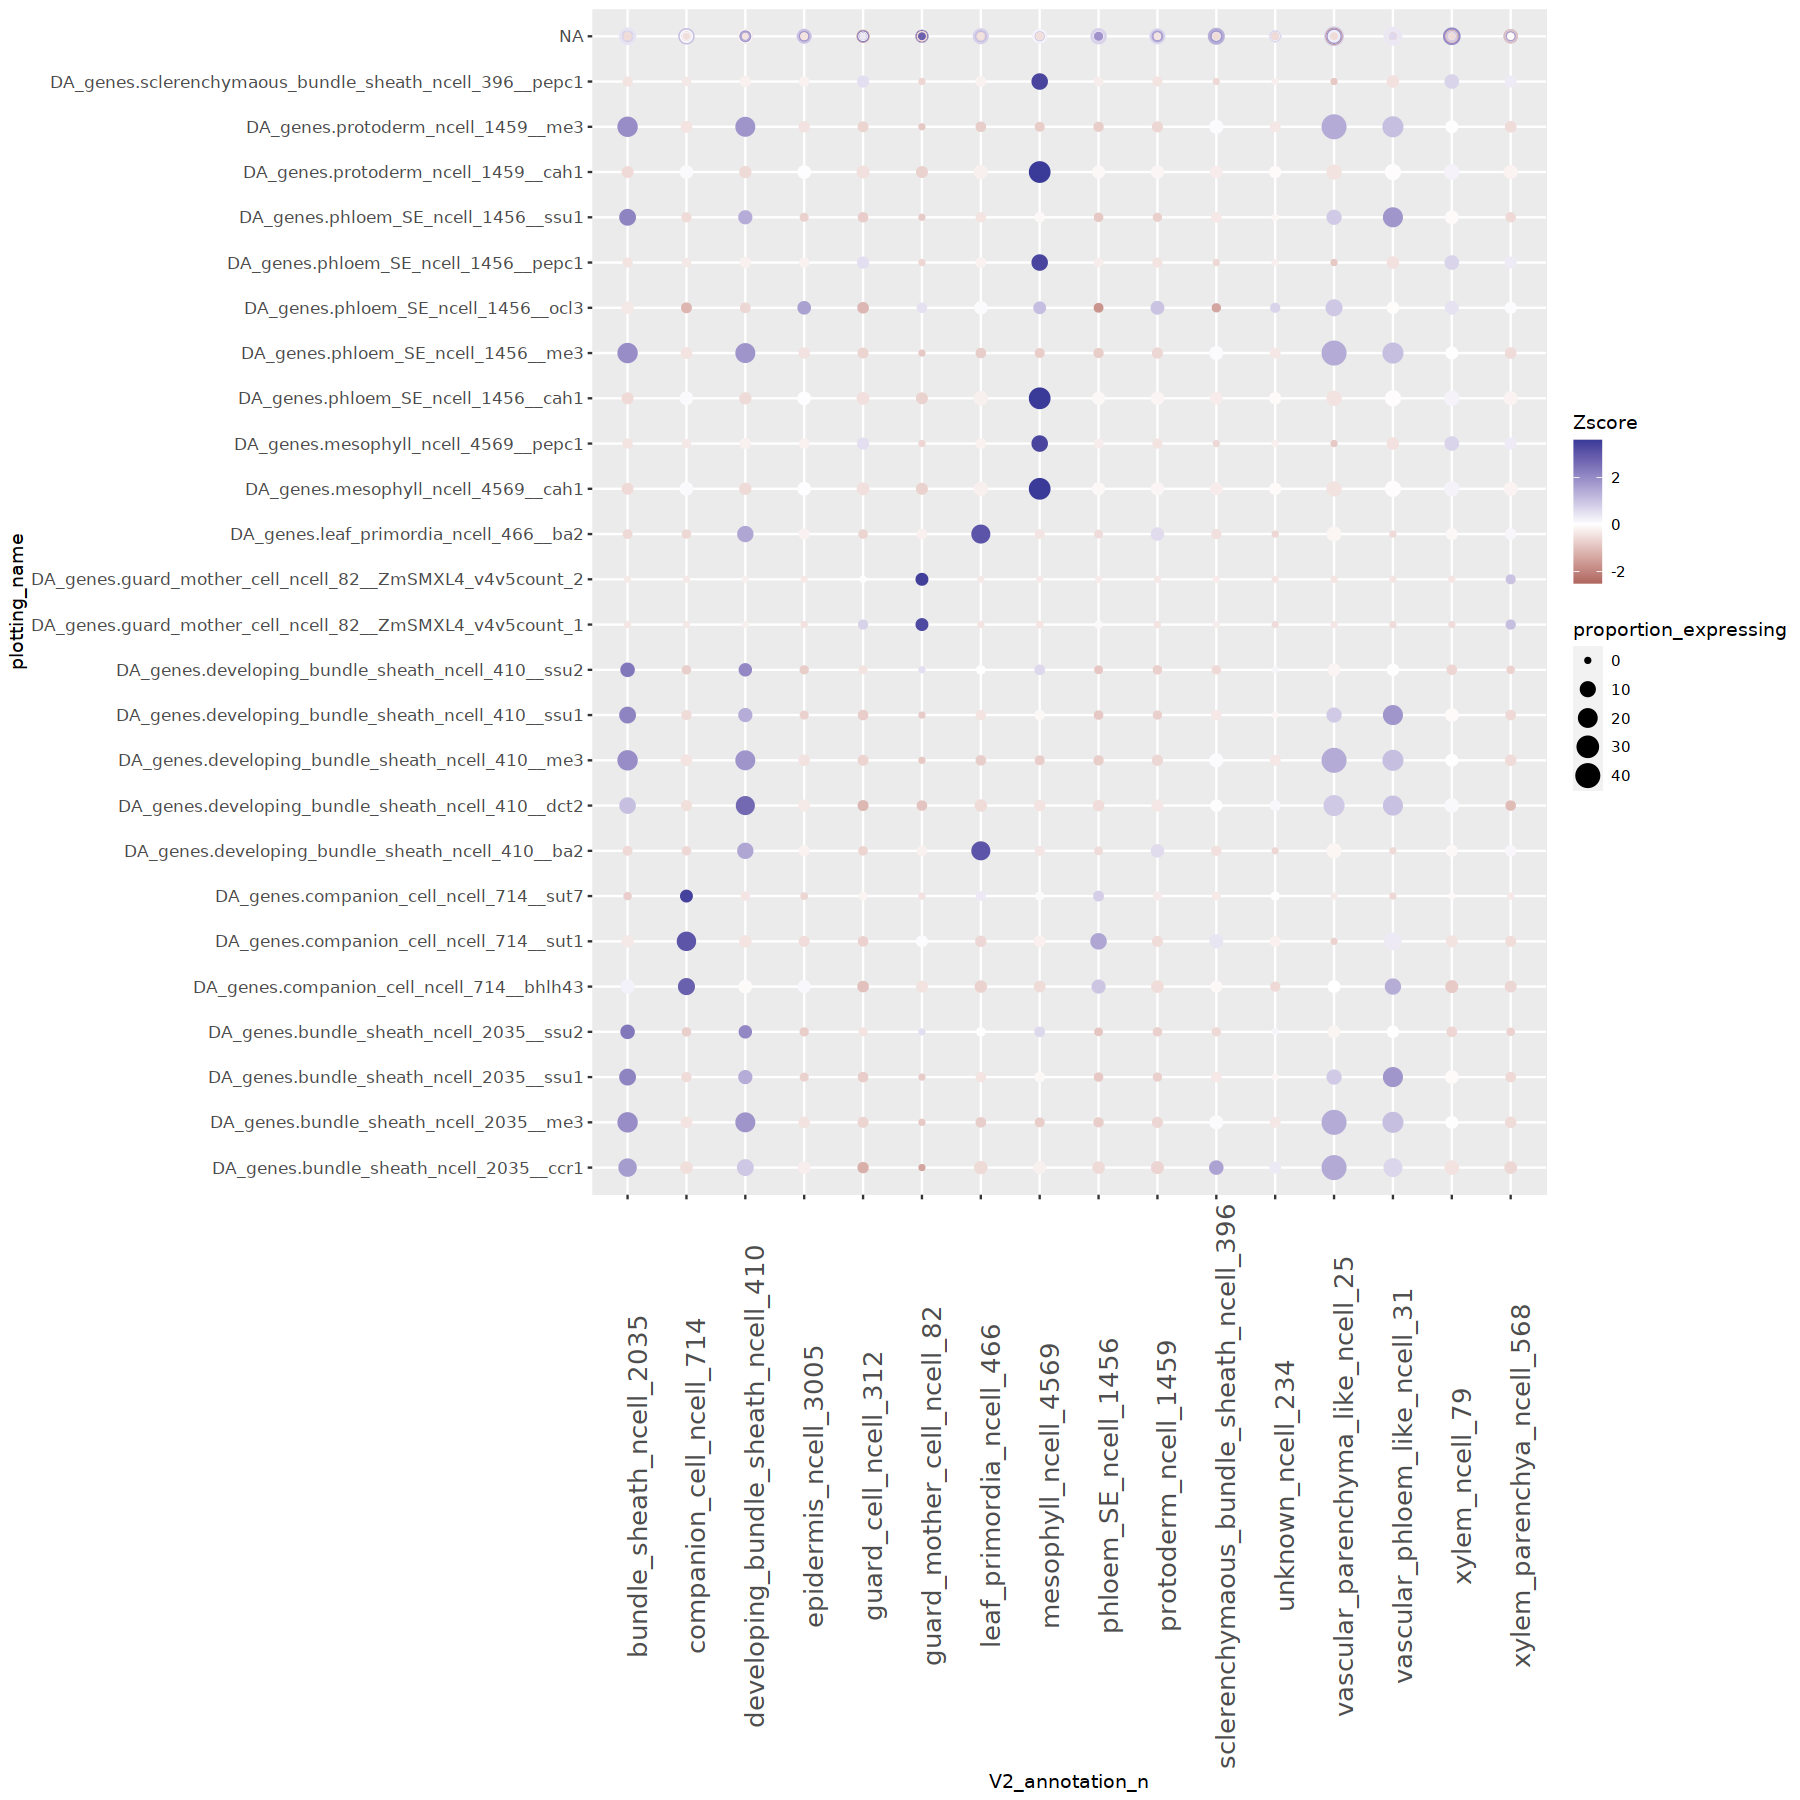

In [26]:
final_plotting_dot <- left_join(altered_deseq2, wider_all_genes_altered, by = c("V2_annotation_n", "geneID")) %>% 
        left_join(., merge_values_altered, by = c("geneID" = "gene_name")) %>% 
        left_join(., gene_markers, by = c("geneID"))  %>% 
        mutate(plotting_name = str_c(origin, name, sep = "__"))  %>% 
        arrange(plotting_name)


library(viridis)
library(repr)
options(repr.plot.width=15, repr.plot.height=15)


ggplot(final_plotting_dot, aes(x=V2_annotation_n, y = plotting_name, 
                               color = Zscore, size = proportion_expressing)) + 
    geom_point() + theme(axis.text.x = element_text(angle = 90)) + scale_colour_gradient2() +
    theme(axis.text.x = element_text(size = 15),
         axis.text.y = element_text(size = 10))   


In [27]:

## Just Markers
altered_deseq2 <- merged_meta_cpm_information_copied %>% 
    dplyr::select(-counts) %>% 
    pivot_wider(names_from = geneID, values_from = grouped_CPM, values_fill = 0) %>% 
    pivot_longer(cols = -V2_annotation_n, names_to = "geneID", values_to = "grouped_CPM") %>% 
    group_by(geneID) %>% 
    mutate(Zscore = scale(grouped_CPM)) %>% 
    ungroup()  %>% 
    #mutate(relative_accessability = rescale(Zscore, to = c(0,1))) %>% 
    group_by(V2_annotation_n)  %>% 
    mutate(Zscore_group = scale(grouped_CPM))


wider_all_genes_altered <- merged_meta_cellID_values_all_genes %>% 
                    filter(geneID %in% all_markers)  %>% 
                    pivot_wider(names_from = geneID, 
                                values_from = accessability,  
                                values_fill = 0) %>% 
                    pivot_longer(cols = c(-V2_annotation_n, -cellID), 
                                 names_to = "geneID", 
                                 values_to = "accessability") %>% 
                    mutate(expression_bool = case_when(accessability <= 2 ~ 0,
                                                       accessability > 2 ~ 1)) %>% 
                    group_by(V2_annotation_n, geneID) %>% 
                    summarise(total_cells = n(), 
                              proportion_expressing = (sum(expression_bool)/total_cells * 100))


`summarise()` has grouped output by 'V2_annotation_n'. You can override using the `.groups` argument.


In [ ]:
head(wider_all_genes_altered)

# Log2FC with Updated DEseq2

In [ ]:
log2fc_values <- all_merge_values_altered  %>% 
    group_by(origin) %>% 
    slice_min(log2FoldChange, n = 5, with_ties = FALSE)  %>% 
    ungroup()

log2fc_sorted <- merged_meta_cpm_information_copied %>% 
    dplyr::select(-counts) %>% 
    pivot_wider(names_from = geneID, values_from = grouped_CPM, values_fill = 0) %>% 
    pivot_longer(cols = -V2_annotation_n, names_to = "geneID", values_to = "grouped_CPM") %>% 
    group_by(geneID) %>% 
    mutate(Zscore = scale(grouped_CPM)) %>% 
    ungroup()  %>% 
    #mutate(relative_accessability = rescale(Zscore, to = c(0,1))) %>% 
    group_by(V2_annotation_n)  %>% 
    mutate(Zscore_group = scale(grouped_CPM)) %>% 
    filter(geneID %in% log2fc_values$gene_name)


# Create Proportion Cells Accessible Metrics ------------------------------
merged_meta_cellID_values <- left_join(meta_data, raw_cpm_counts_all_genes, by = c("cellID"))
take_unq_genes <- unique(merged_meta_cellID_values$geneID)


merged_meta_cellID_values_all_genes <- merged_meta_cellID_values %>% 
    select(cellID, V2_annotation_n, accessability, geneID) 


cell_accessability_wider_all_genes <- merged_meta_cellID_values_all_genes %>% 
                    filter(geneID %in% log2fc_values$gene_name) %>% 
                    pivot_wider(names_from = geneID, 
                                values_from = accessability,  
                                values_fill = 0) %>% 
                    pivot_longer(cols = c(-V2_annotation_n, -cellID), 
                                 names_to = "geneID", 
                                 values_to = "accessability") %>% 
                    mutate(expression_bool = case_when(accessability <= 2 ~ 0,
                                                       accessability > 2 ~ 1)) %>% 
                    group_by(V2_annotation_n, geneID) %>% 
                    summarise(total_cells = n(), 
                              proportion_expressing = (sum(expression_bool)/total_cells * 100))



log2fc_genes <-  left_join(log2fc_sorted, cell_accessability_wider_all_genes, by = c("V2_annotation_n", "geneID")) %>% 
        left_join(., log2fc_values, by = c("geneID" = "gene_name")) %>% 
        mutate(plotting_name = str_c(origin,geneID, sep = "__"))



options(repr.plot.width=15, repr.plot.height=15)
ggplot(log2fc_genes, aes(x=V2_annotation_n, y = plotting_name, 
                               color = Zscore, size = proportion_expressing)) + 
    geom_point() + theme(axis.text.x = element_text(angle = 90)) + scale_colour_gradient2()

# Proportion of Cells Accessible

In [ ]:
#subsampled_merged_meta_cellID_values_all_genes <- merged_meta_cellID_values_all_genes[sample(nrow(merged_meta_cellID_values_all_genes), 200), ]
#size_test <- pivot_wider(subsampled_merged_meta_cellID_values_all_genes, 
 #                        names_from = geneID, values_from = accessability)
#View(head(merged_meta_cellID_values_all_genes))



unique(merged_meta_cellID_values_all_genes$V2_annotation_n)
    
test_data_set <- merged_meta_cellID_values_all_genes %>% 
    filter(V2_annotation_n == "mesophyll_ncell_4569")


test_data_set %>% 
    filter(geneID %in% merge_values$gene_name) %>% 
    ggplot(., aes((accessability))) + geom_histogram(binwidth = 1) + facet_wrap(geneID~.)
    


test_data_set %>% 
    filter(geneID %in% merge_values$gene_name) %>% 
    ggplot(., aes(log2(accessability))) + geom_histogram(binwidth = 1) + facet_wrap(geneID~.)


colnames(test_data_set)
hist(log(test_data_set$accessability))

In [ ]:
colnames(merged_meta_cellID_values_all_genes)

In [ ]:
# Generral Accessability --------------------------------------------------


View(raw_cpm_counts_all_genes)

all_genes <- unique(merged_meta_cellID_values_all_genes$geneID)
colnames(merged_meta_cellID_values_all_genes)

x <- merged_meta_cellID_values_all_genes %>% 
    group_by(V2_annotation_n, geneID) %>% 
    summarise(mean_gene_accessability = mean(accessability, na.rm = TRUE)) %>% 
    mutate(expression_bool = case_when(mean_gene_accessability < 1 ~ 0,
                                       mean_gene_accessability > 1 ~ 1)) 
    summarise(total_cells = n(), 
              proportion_expressing = (sum(expression_bool)/total_cells * 100))

View(x)

In [ ]:
x <- pivot_wider(merged_meta_cellID_values_all_genes, 
            names_from = geneID, 
            values_from = accessability,  
            values_fill = 0)  %>% 
     pivot_longer(cols = c(-V2_annotation_n, -cellID), 
                                 names_to = "geneID", 
                                 values_to = "accessability")

In [ ]:
x %>% 
    group_by(cellID, V2_annotation_n)  %>% 
    summarise(n())  %>% 
    head()

In [ ]:
proportion_accessible <- x  %>% 
    mutate(expression_bool = case_when(accessability == 0 ~ 0,
                                       accessability >= 1 ~ 1)) %>%
    ungroup()  %>% 
    group_by(V2_annotation_n, geneID) %>% 
    summarise(total_cells = n(),
              total_accessible = sum(expression_bool),
              proportion_accessible = ((total_accessible/total_cells) * 100))
    

In [ ]:
x %>% 
    filter(V2_annotation_n == "mesophyll_ncell_4569")  %>% 
    mutate(expression_bool = case_when(accessability == 0 ~ 0,
                                       accessability >= 1 ~ 1)) %>%
    ungroup()  %>% 
    group_by(V2_annotation_n, geneID) %>% 
    summarise(total_cells = n(),
              total_accessible = sum(expression_bool),
              proportion_accessible = ((total_accessible/total_cells) * 100))



In [ ]:
library(repr)
options(repr.plot.width=10, repr.plot.height=10)

ggplot(proportion_accessible, aes(x = proportion_accessible)) + 
    geom_density() + facet_wrap(V2_annotation_n~.)

In [ ]:

options(repr.plot.width=10, repr.plot.height=10)

proportion_accessible  %>% 
    filter(proportion_accessible > 10)  %>% 
ggplot(., aes(x = proportion_accessible)) + 
    geom_histogram(binwidth = 1) + facet_wrap(V2_annotation_n~.,scales = "free_y")

In [ ]:

options(repr.plot.width=10, repr.plot.height=10)

proportion_accessible  %>%  
ggplot(., aes(x = proportion_accessible)) + 
    geom_histogram(binwidth = 1) + facet_wrap(V2_annotation_n~.,scales = "free_y")

In [ ]:
proportion_accessible  %>% 
ggplot(., aes(x = proportion_accessible)) + 
    geom_histogram(binwidth = 1) + facet_wrap(V2_annotation_n~.)